# Introduction

Over the past few years we have witnessed a number of significant global political and macroeconomic events.  In my work I have frequently come across time series which show markedly different behaviour pre 2020 to post 2020.  Disruption and change are the forecaster's enemy.

In this notebook I attempt to forecast the price of petrol at the pump (in the UK) eight weeks ahead.  

As a secondary objective, I am curious as to the ability of modern, deep learning methods to compete with traditional, statistical models in predicting a volatile time series.  In 2017 Makridakis et al published a paper titled _Statistical and Machine Learning forecasting methods: Concerns and ways forward_ (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0194889) in which they observed that traditional time series methods frequently still worked better than deep learning methods.  At the time I followed this up carefully and broadly corroborated the claims. I was curious to try again using a modern method like Amazon's DeepAR model (https://arxiv.org/abs/1704.04110) or Google's Temporal Fusion Transformer (https://arxiv.org/abs/1912.09363) and compare it to some traditional, statistical methods.

So where to start?

According to the RAC (https://www.rac.co.uk/drive/advice/fuel-prices/what-affects-the-price-of-fuel/) the price of petrol at the pump depends on the following factors:

- The global price of crude oil.  I gathered this Investing.com (https://uk.investing.com/etfs/etfs-brent-crude-historical-data). I also took Natural gas prices from the same site as, for some use cases, it is a substitute good.
- Supply and demand for crude oil.  I couldn't find metrics for these but BEIS do publish metrics for UK forecourts for stock levels, deliveries and sales.  I used these as a proxy for supply & demand of petrol itself. (https://www.gov.uk/government/statistics/average-road-fuel-sales-and-stock-levels)
- Refinery production and capacity.  I collected these from JodiOil (https://www.jodidata.org/oil/database/data-downloads.aspx).
- Phe pound to dollar exchange rate, as refined fuel is sold in US dollars.  I gathered this from xe.com.
- Distribution costs.  I couldn't find metrics for this.
- The margin fuel retailers decide to take.  I couldn't find metrics for this.
- Fuel duty and VAT.  This is available in the BEIS data but didn't have much of an impact on the analysis and has been removed from this notebook.

The pump prices themselves are also available from BEIS, as are fuel duty and VAT numbers.  (https://www.gov.uk/government/statistics/weekly-road-fuel-prices)

The RAC also publishes wholesale prices in the UK (https://datawrapper.dwcdn.net/D7n0J/17/) but the source data itself is not easy to extract and is not used in this notebook.

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from copy import deepcopy
from tqdm import tqdm
from itertools import count
import warnings
    
from sklearn import metrics
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

import pytorch_forecasting as ptf
from pytorch_forecasting import DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import MultivariateNormalDistributionLoss

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [2]:
# Some minor warnings appear in this committed version.  I've hidden them as they're nothing important.
warnings.filterwarnings('ignore')

In [3]:
# We will attempt to forecast the pump price 8 weeks ahead.
FORECAST_PERIOD = 8    

In [4]:
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)
sns.set(rc={'figure.figsize':(15,5)})

Global seed set to 42


The columns in the data are:

- `global_refinary_output`: Monthly crude production in millions of barrels from Jodi.  I used linear interpolation to get to weekly figures.
- `avg_stock_level`: Average % of maximum stocking level from petrol stations sampled by BEIS.  Weekly data.
- `avg_road_fuel_deliveries`:  Average number of fuel deliveries (litres) from petrol stations sampled by BEIS.  Weekly data.
- `avg_road_fuel_sales`:   Average number of fuel sales (litres) from petrol stations sampled by BEIS.  Weekly data.
- `gbp_to_usd_xrate`: Weekly British Pound to US Dollar exchange rate.  Daily data down-sampled to weekly.
- `brent_crude_price`: In USD. From Investing.com.  Daily data down-sampled to weekly.
- `ngas_price`: In USD. From Investing.com.  Daily data down-sampled to weekly.
- `brent_crude_price_range`: From the Investing.com data.  The MAX - MIN price within a week.  Used as a proxy for price volatility.

In [5]:
df = pd.read_csv(
    'data.csv',     
    parse_dates=['date'],
    infer_datetime_format=True,
    dayfirst=True
)

In [6]:
# The factors which should impact upon the pump price.
features = [
    'global_refinary_output', 'avg_stock_level', 'avg_road_fuel_deliveries', 'avg_road_fuel_sales', 
    'gbp_to_usd_xrate', 'brent_crude_price', 'ngas_price', 'brent_crude_price_range'
]

# This is what we'll try to predict.
target = 'petrol_pump_price'

# The date of each observation.
date = 'date'

# We create an integer "time index" for the dataset.  This is used by pytorch_forecasting later on.
time_idx = 'time_idx'
df['time_idx'] = range(df.shape[0])

df = df[features + [target, date, time_idx]]

# EDA

First we need to plot each of the time series separately.

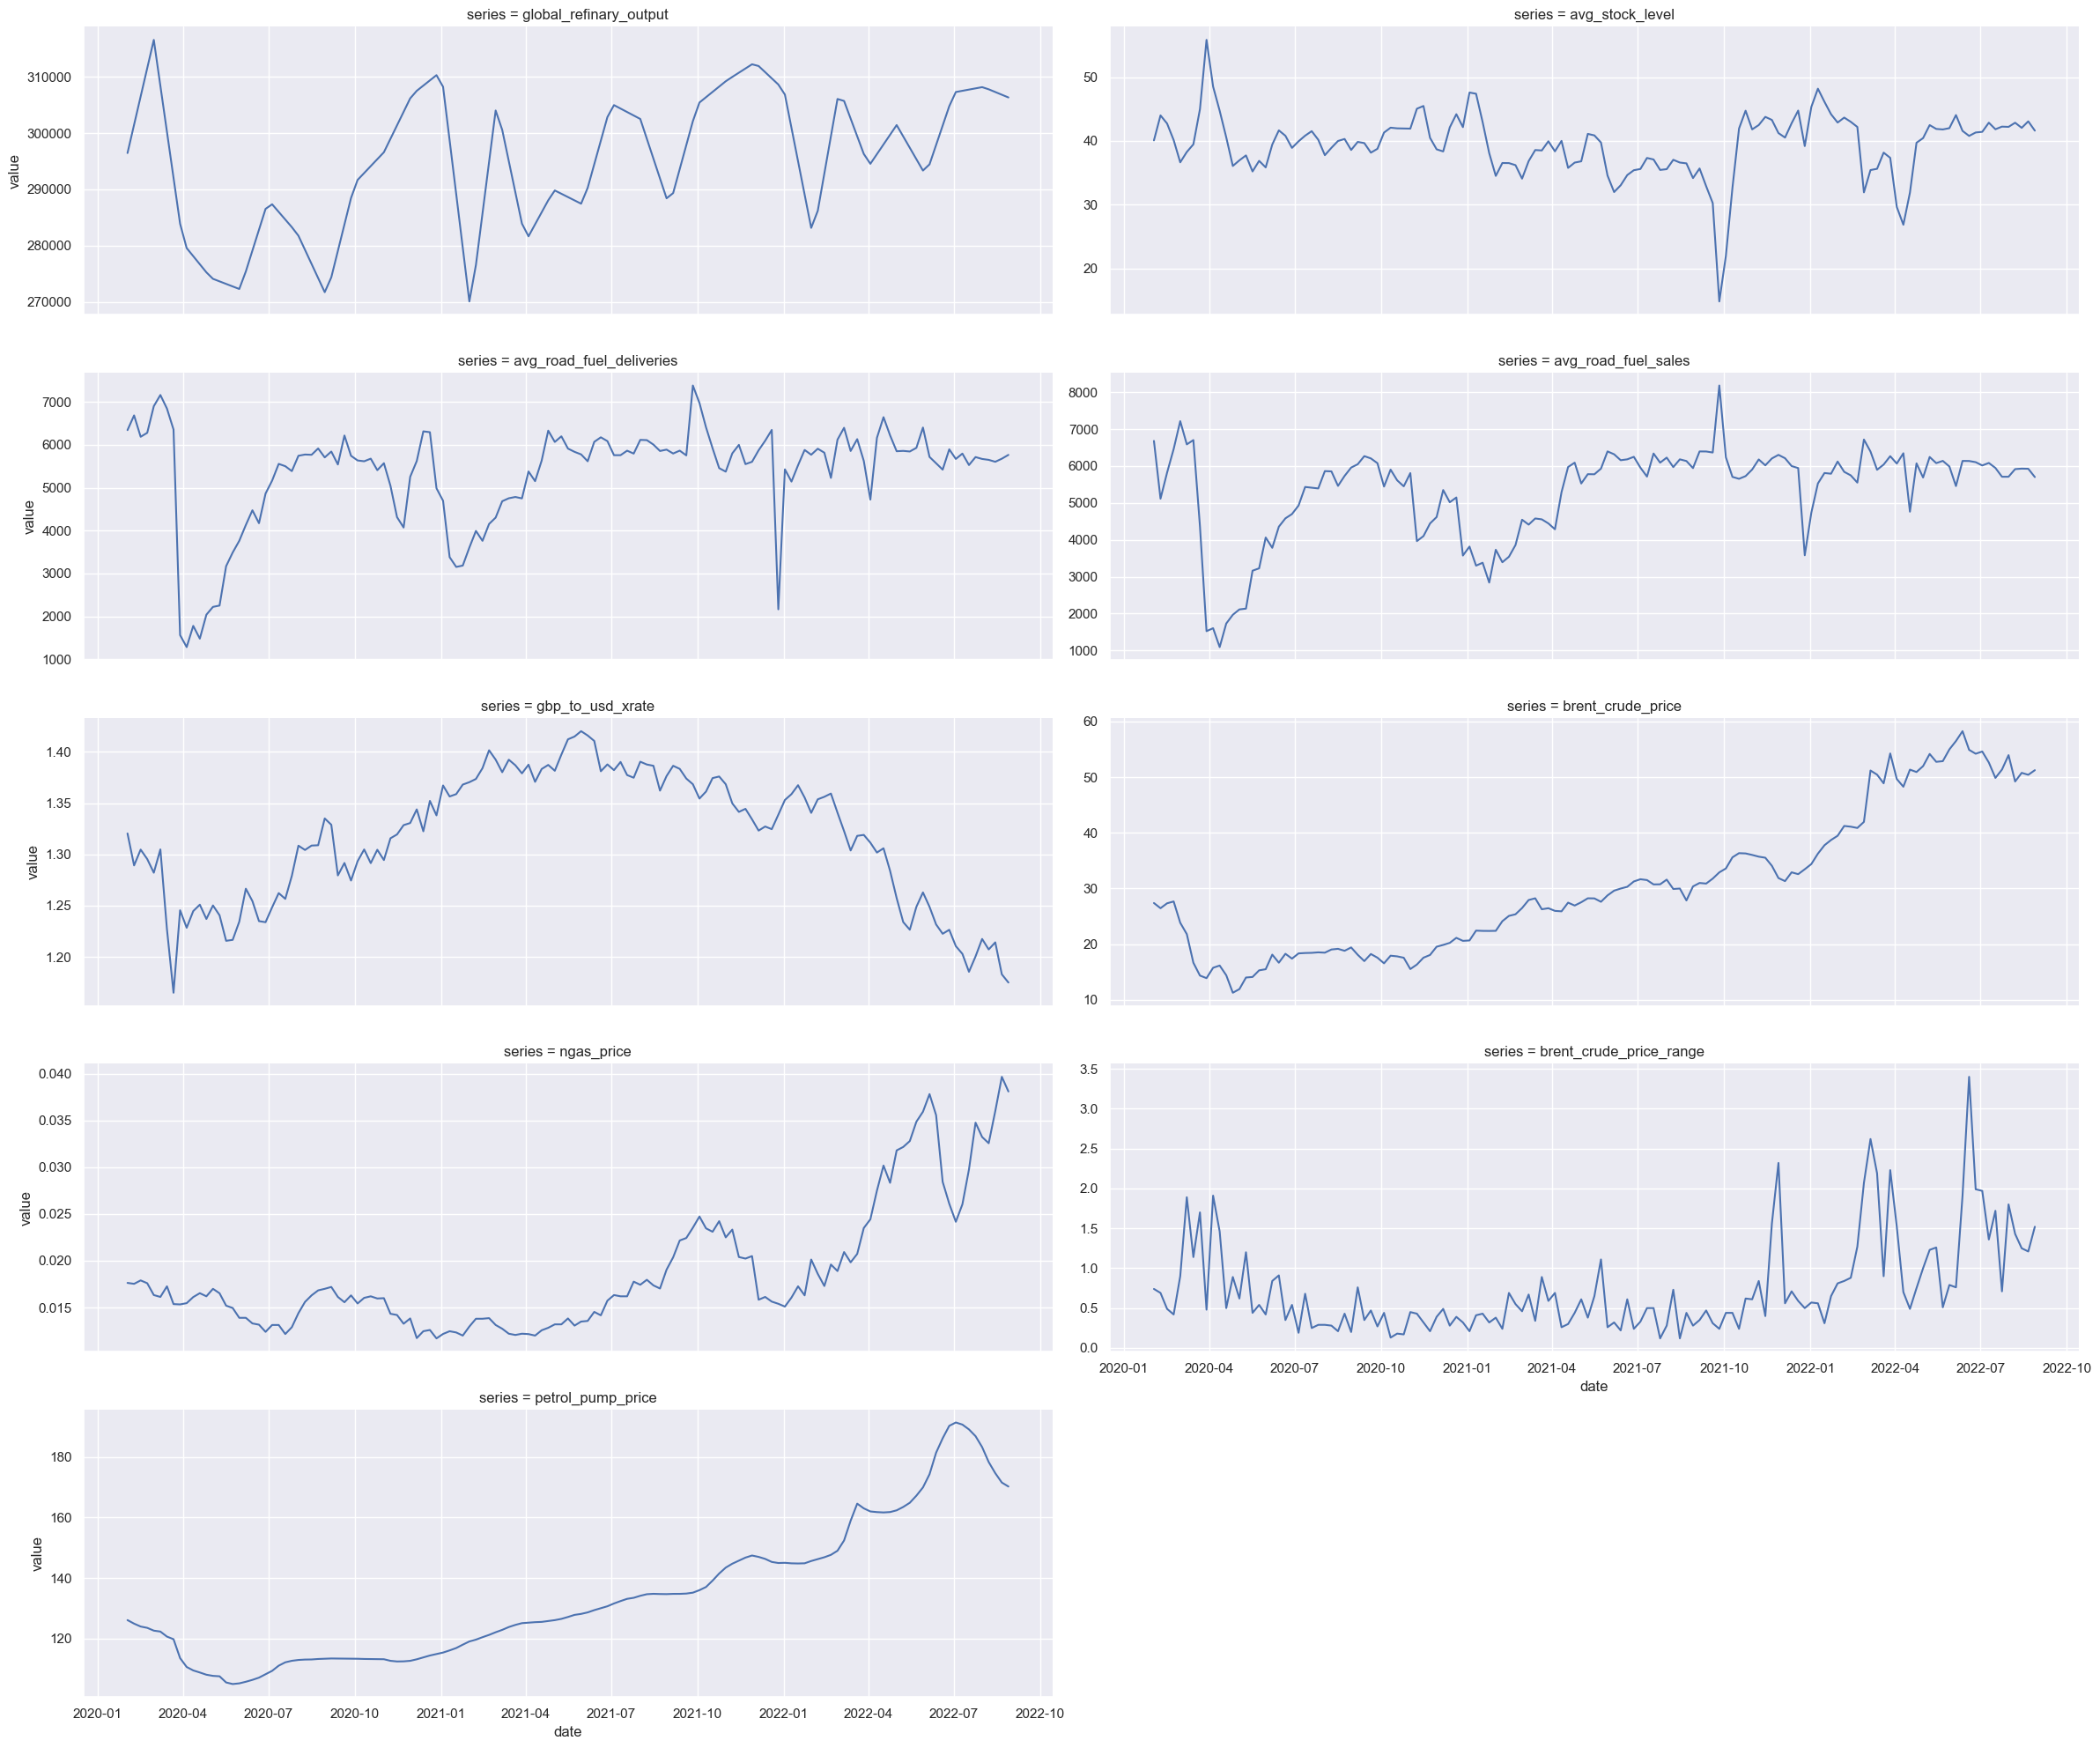

In [7]:
g = sns.FacetGrid(
    df.melt(
        id_vars=[date, time_idx], 
        value_vars=features + [target], 
        var_name='series', 
        value_name='value'
    ), 
    col='series', 
    height=4, 
    col_wrap=2, 
    aspect=3, 
    sharey=False
)

g.map(sns.lineplot, 'date', 'value')

- We can see signficant "spikes" in many of the series, which might represent regime changes in the data.  Some of these appear to correlate with significant, recent events, for example:
  - The start of the first of the UK's Coronavirus "lockdowns" on 16/03/20.
  - The final lifting of the UK's Coronavirus travel restrictions on 27/11/21.
  - The Russian invasion of the Ukraine commencing 24/02/22.
- There appear to be non-linear trends in several of the time series: `petrol_pump_price`, `ngas_price`, `brent_crude_price`, `GBP_to_USD_xrate`.
- The `brent_crude_price` (at least) appears to be heteroskedastic throughout.

We can anticipate that many of these series will be non-stationary, thanks to the combination of apparent "shocks" to some of the series and clear macro-trends in others observed above.

We can verify this with a so-called "unit root" test.  The Augmented Dickey-Fuller test is a suitable option.  Here, the null hypothesis is that the series is non-stationary.

In [8]:
def adf_test(df, features):
    for f in features:
        result = adfuller(df[f])
        yield {'feature': f, 'p_value': result[1]}
        
pd.DataFrame(list(adf_test(df, features + [target])))

feature   p_value
0    global_refinary_output  0.221065
1           avg_stock_level  0.000004
2  avg_road_fuel_deliveries  0.007530
3       avg_road_fuel_sales  0.056448
4          gbp_to_usd_xrate  0.773041
5         brent_crude_price  0.945370
6                ngas_price  0.947096
7   brent_crude_price_range  0.978388
8         petrol_pump_price  0.988485

As expected, several of the series would fail a hypothesis test at the 5% level.  The simplest thing to do is to take the first difference of each series and check whether we have achieved stationarity.

In [9]:
stationary_df = df.set_index([date, time_idx]).diff().dropna().reset_index()

In [10]:
pd.DataFrame(list(adf_test(stationary_df, features + [target])))

feature       p_value
0    global_refinary_output  5.936617e-05
1           avg_stock_level  1.423368e-15
2  avg_road_fuel_deliveries  5.152150e-25
3       avg_road_fuel_sales  3.827530e-24
4          gbp_to_usd_xrate  3.926929e-24
5         brent_crude_price  2.347955e-06
6                ngas_price  1.390212e-17
7   brent_crude_price_range  2.685457e-09
8         petrol_pump_price  4.489373e-02

So that's done the job nicely.  We can plot the series again.

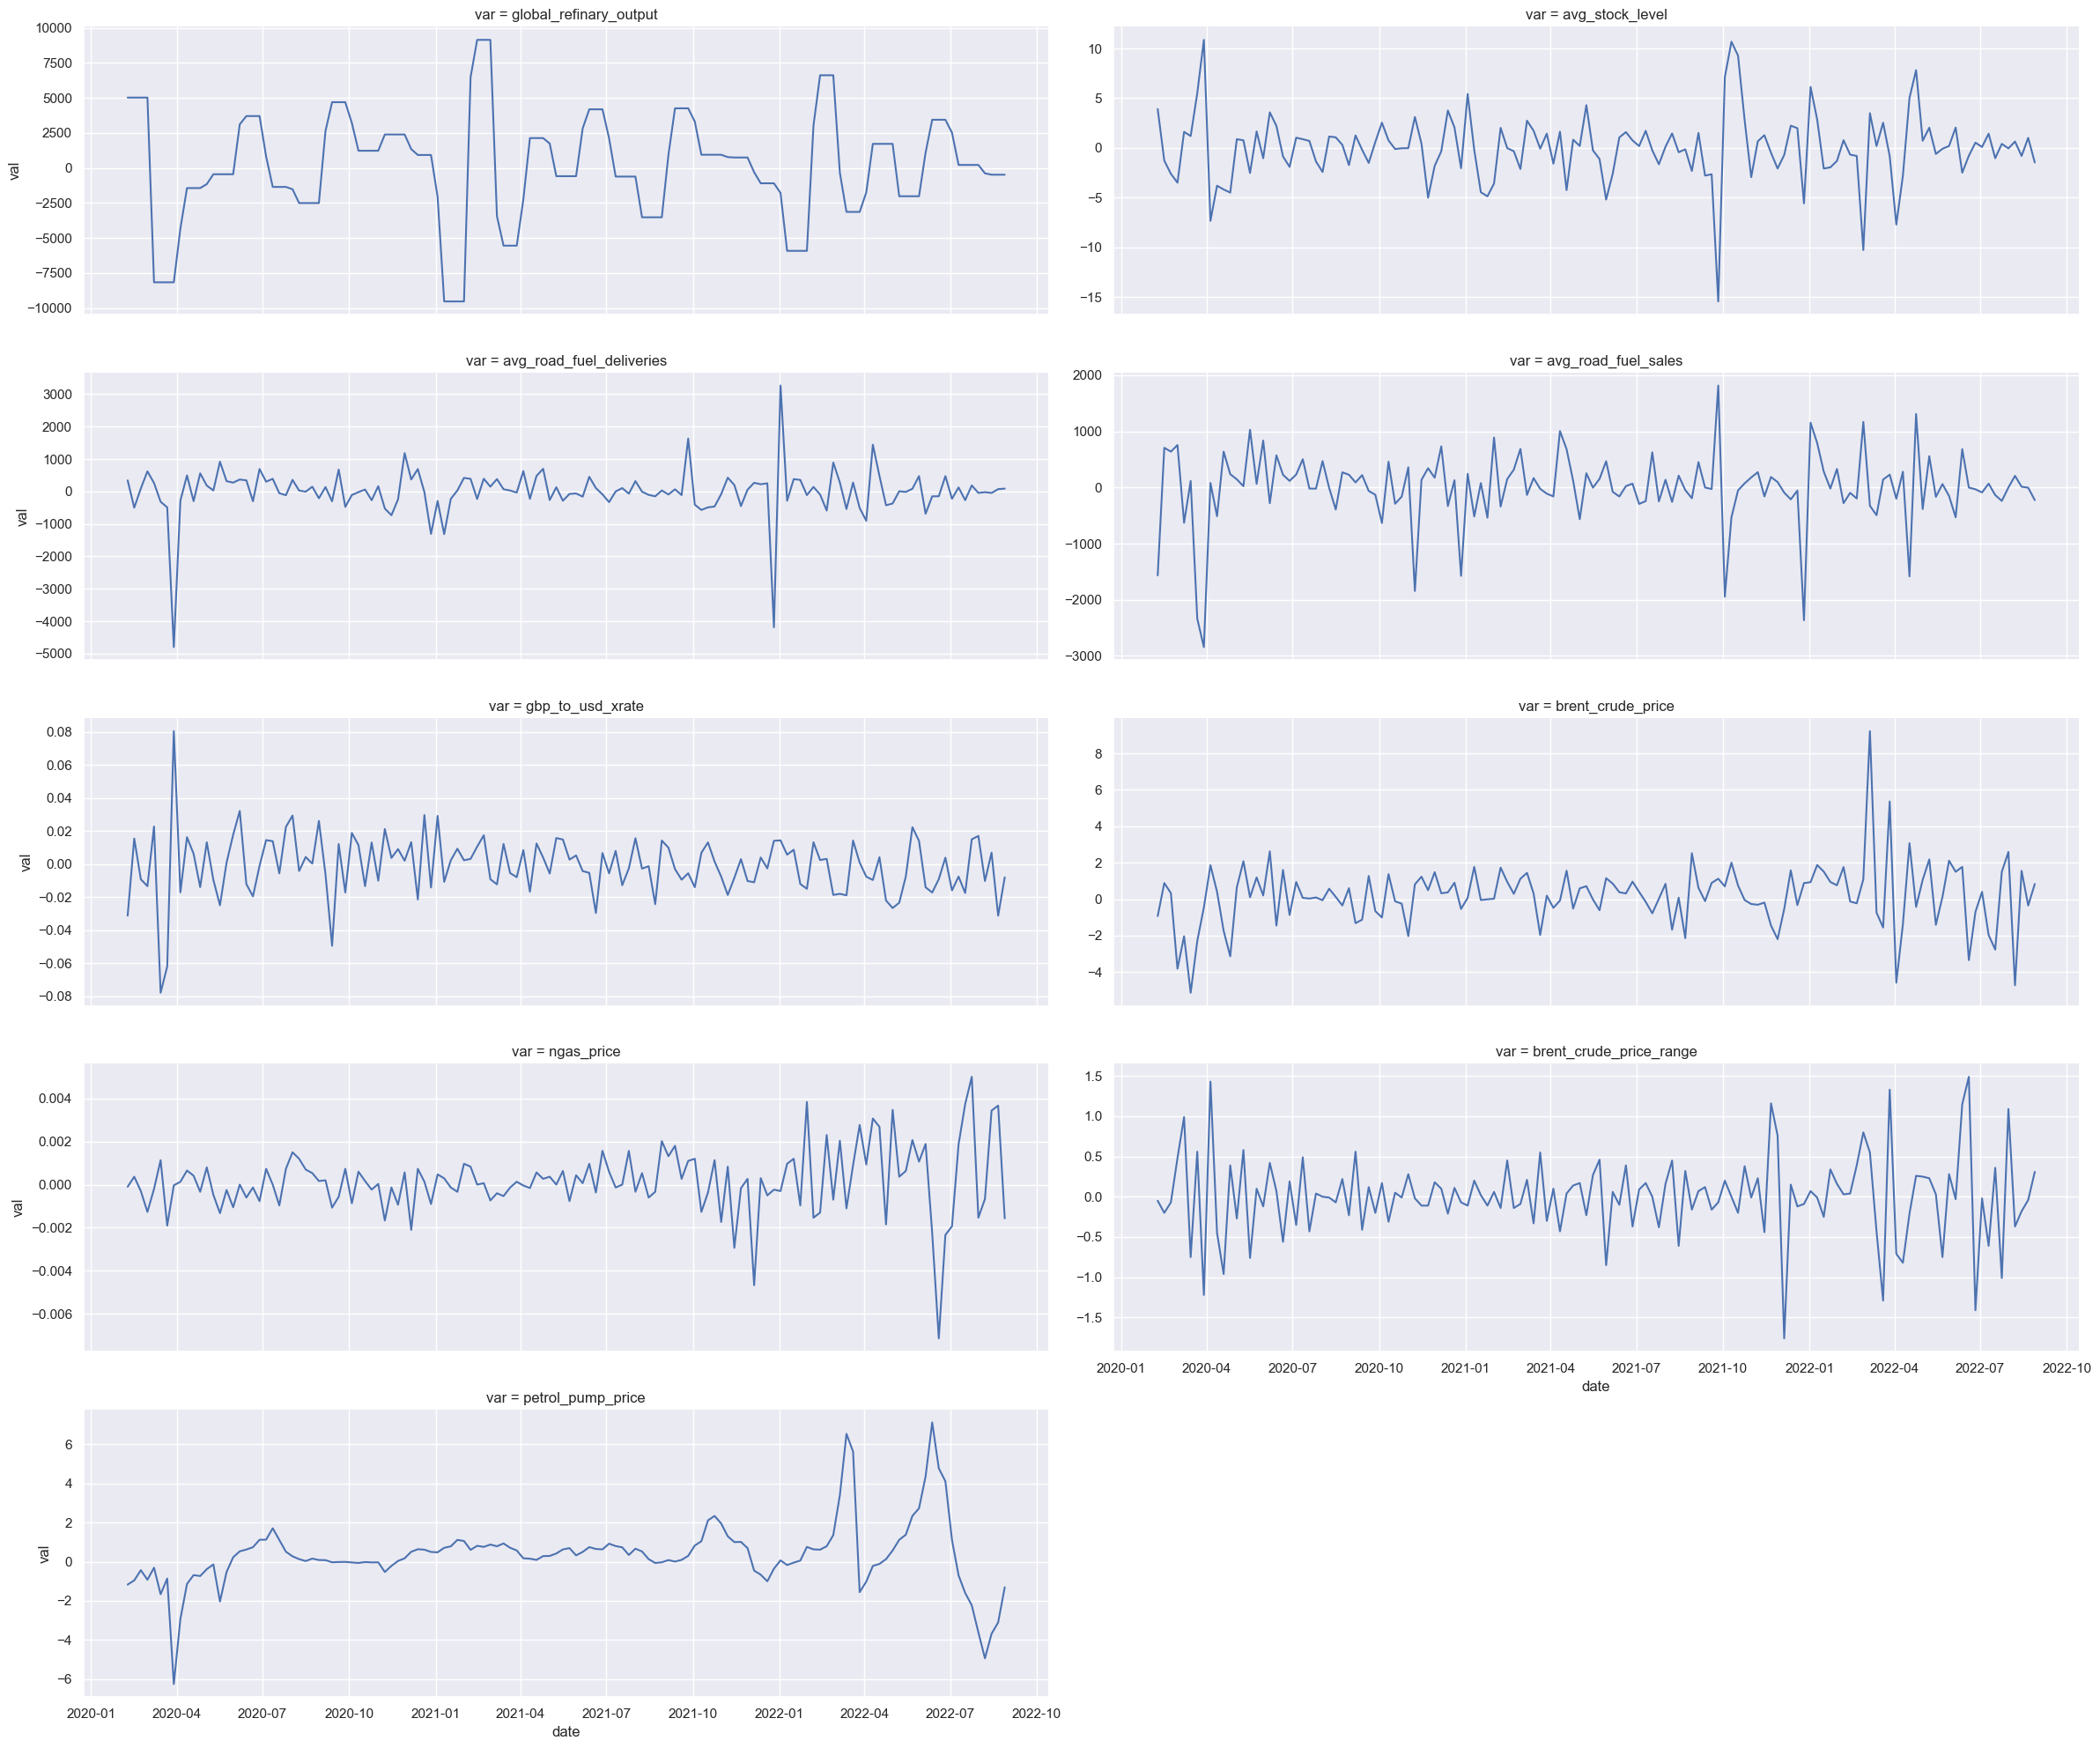

In [11]:
g = sns.FacetGrid(
    stationary_df.melt(
        id_vars='date', 
        value_vars=features + [target], 
        var_name='var', 
        value_name='val'
    ), 
    col='var', 
    height=4, 
    col_wrap=2, 
    aspect=3, 
    sharey=False
)

g.map(sns.lineplot, 'date', 'val')

The heterosketasticity in the series is much clearer now.  We could control for this by using a variance-stabilising transform but, since the ADF tests look OK, we'll continue as is for now.

Next up we'll take a look at the auto-correlation and partial auto-correlation plots for each series.

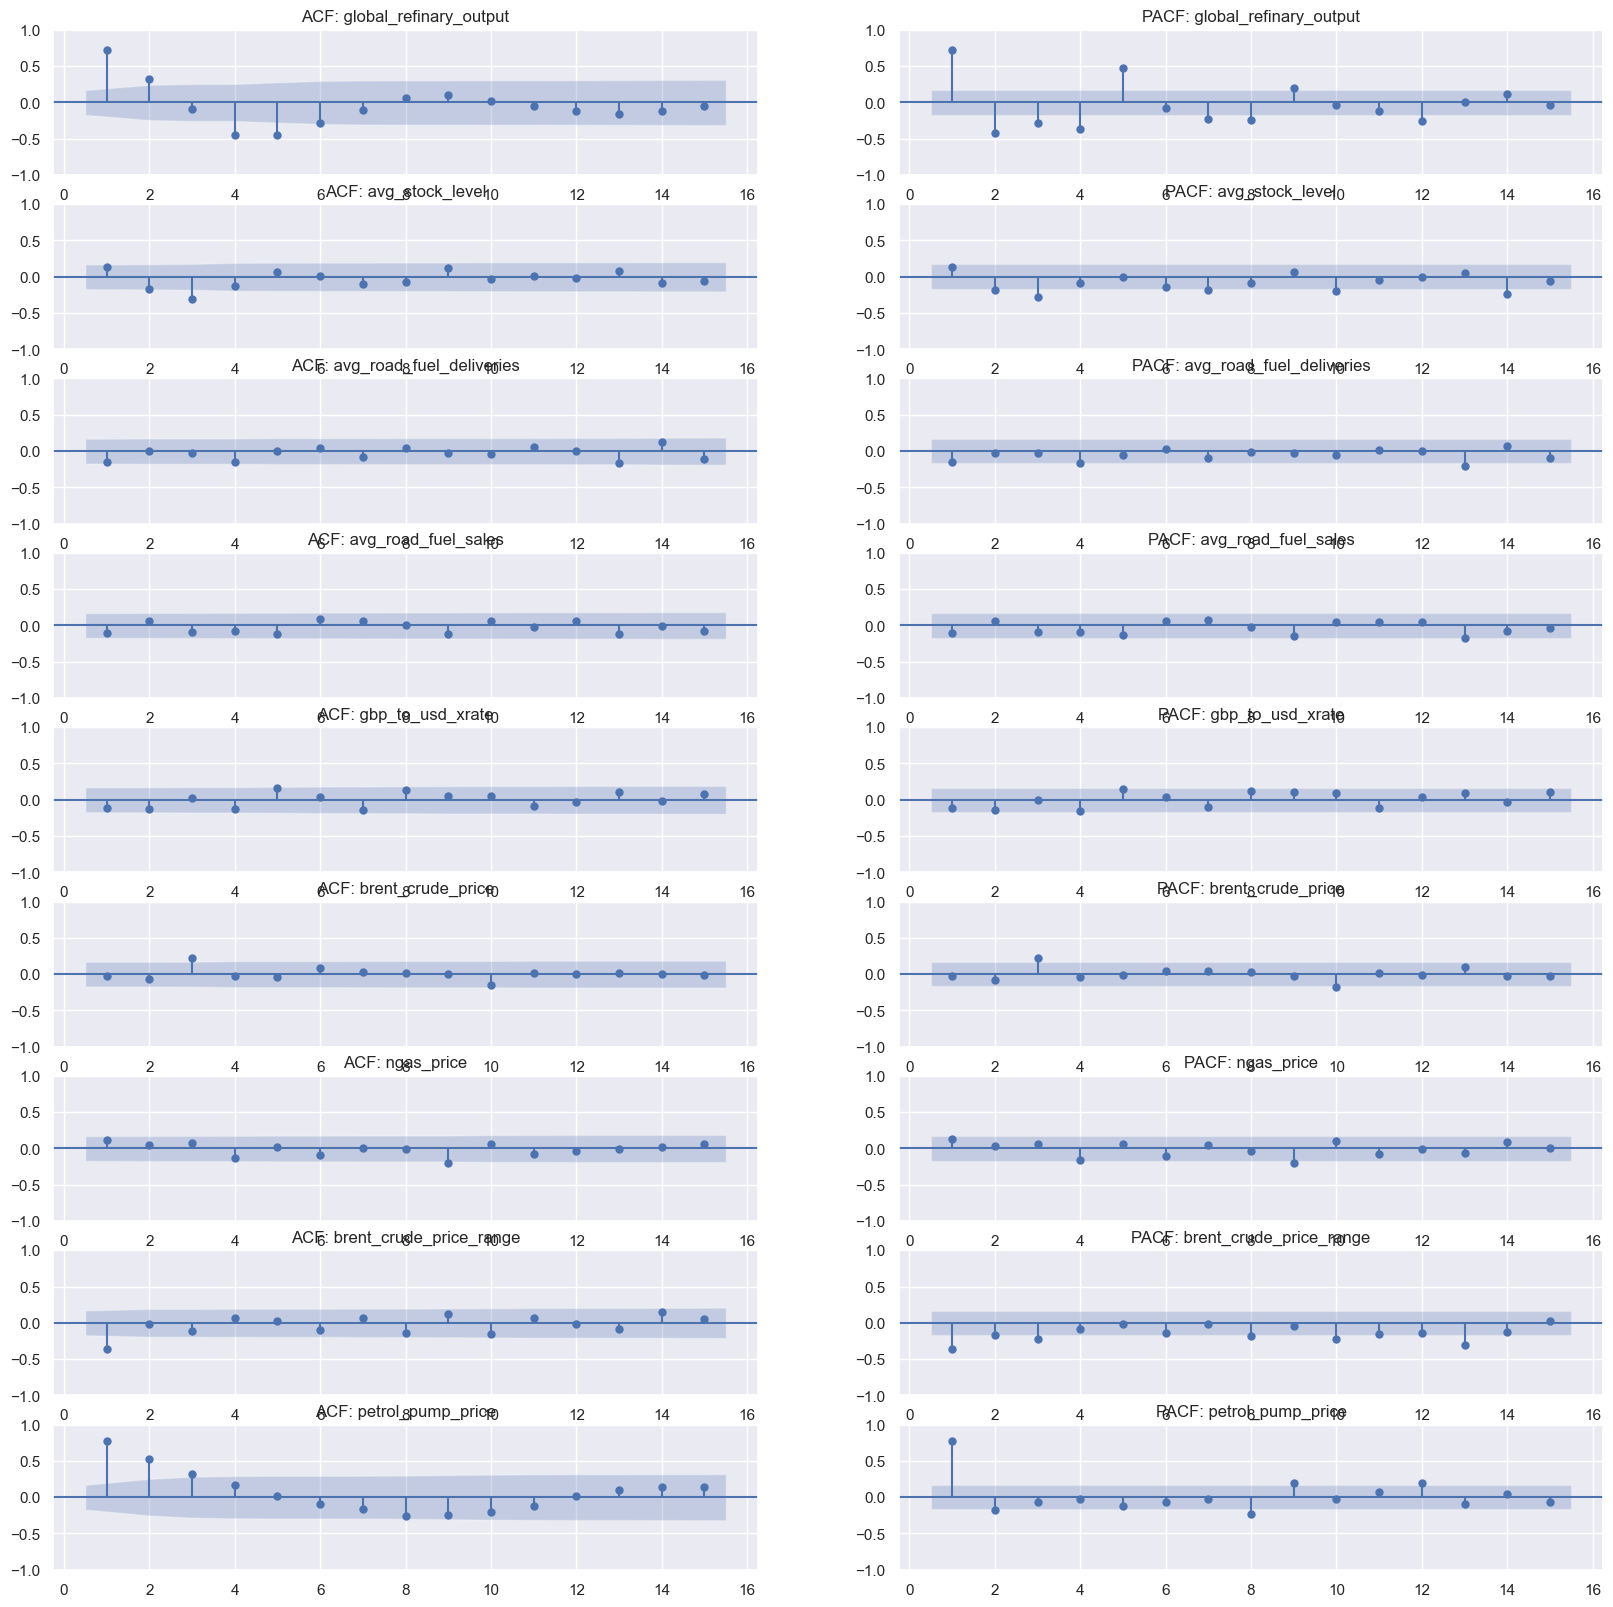

In [12]:
plt.figure(figsize = (20, 20))

n_lags = 15

indexer = count(1)

n_rows = len(features + [target])

for f in features + [target]:
    plt.subplot(n_rows, 2, next(indexer))
    plot_acf(stationary_df[f], lags=n_lags, ax=plt.gca(), zero=False, title=f"ACF: {f}")
    plt.subplot(n_rows, 2, next(indexer))
    plot_pacf(stationary_df[f], lags=n_lags, ax=plt.gca(), zero=False, title=f"PACF: {f}")

So, the plots make it clear that this isn't going to be an easy task.  Only `petrol_pump_price` and (potentially) `global_refinary_output` show any indications of auto-regressive behaviour (decaying patterns in the ACF plot).  `global_refinary_output` (and possibly `petrol_pump_price`) show indications of moving-average behaviour (significant +/- spikes in the PACF plots).  Most of the other series look pretty close to noise.

# TODO: PERIODICITY ANALYSIS

# Cross-Correlation

Just to deepen our fear that this is a difficult prediction task we can look for any clear correlations between the different series.  Here we are using a Kernel Density Estimation procedure to estimate the joint density of each pair of series and rendering it with a contour plot.

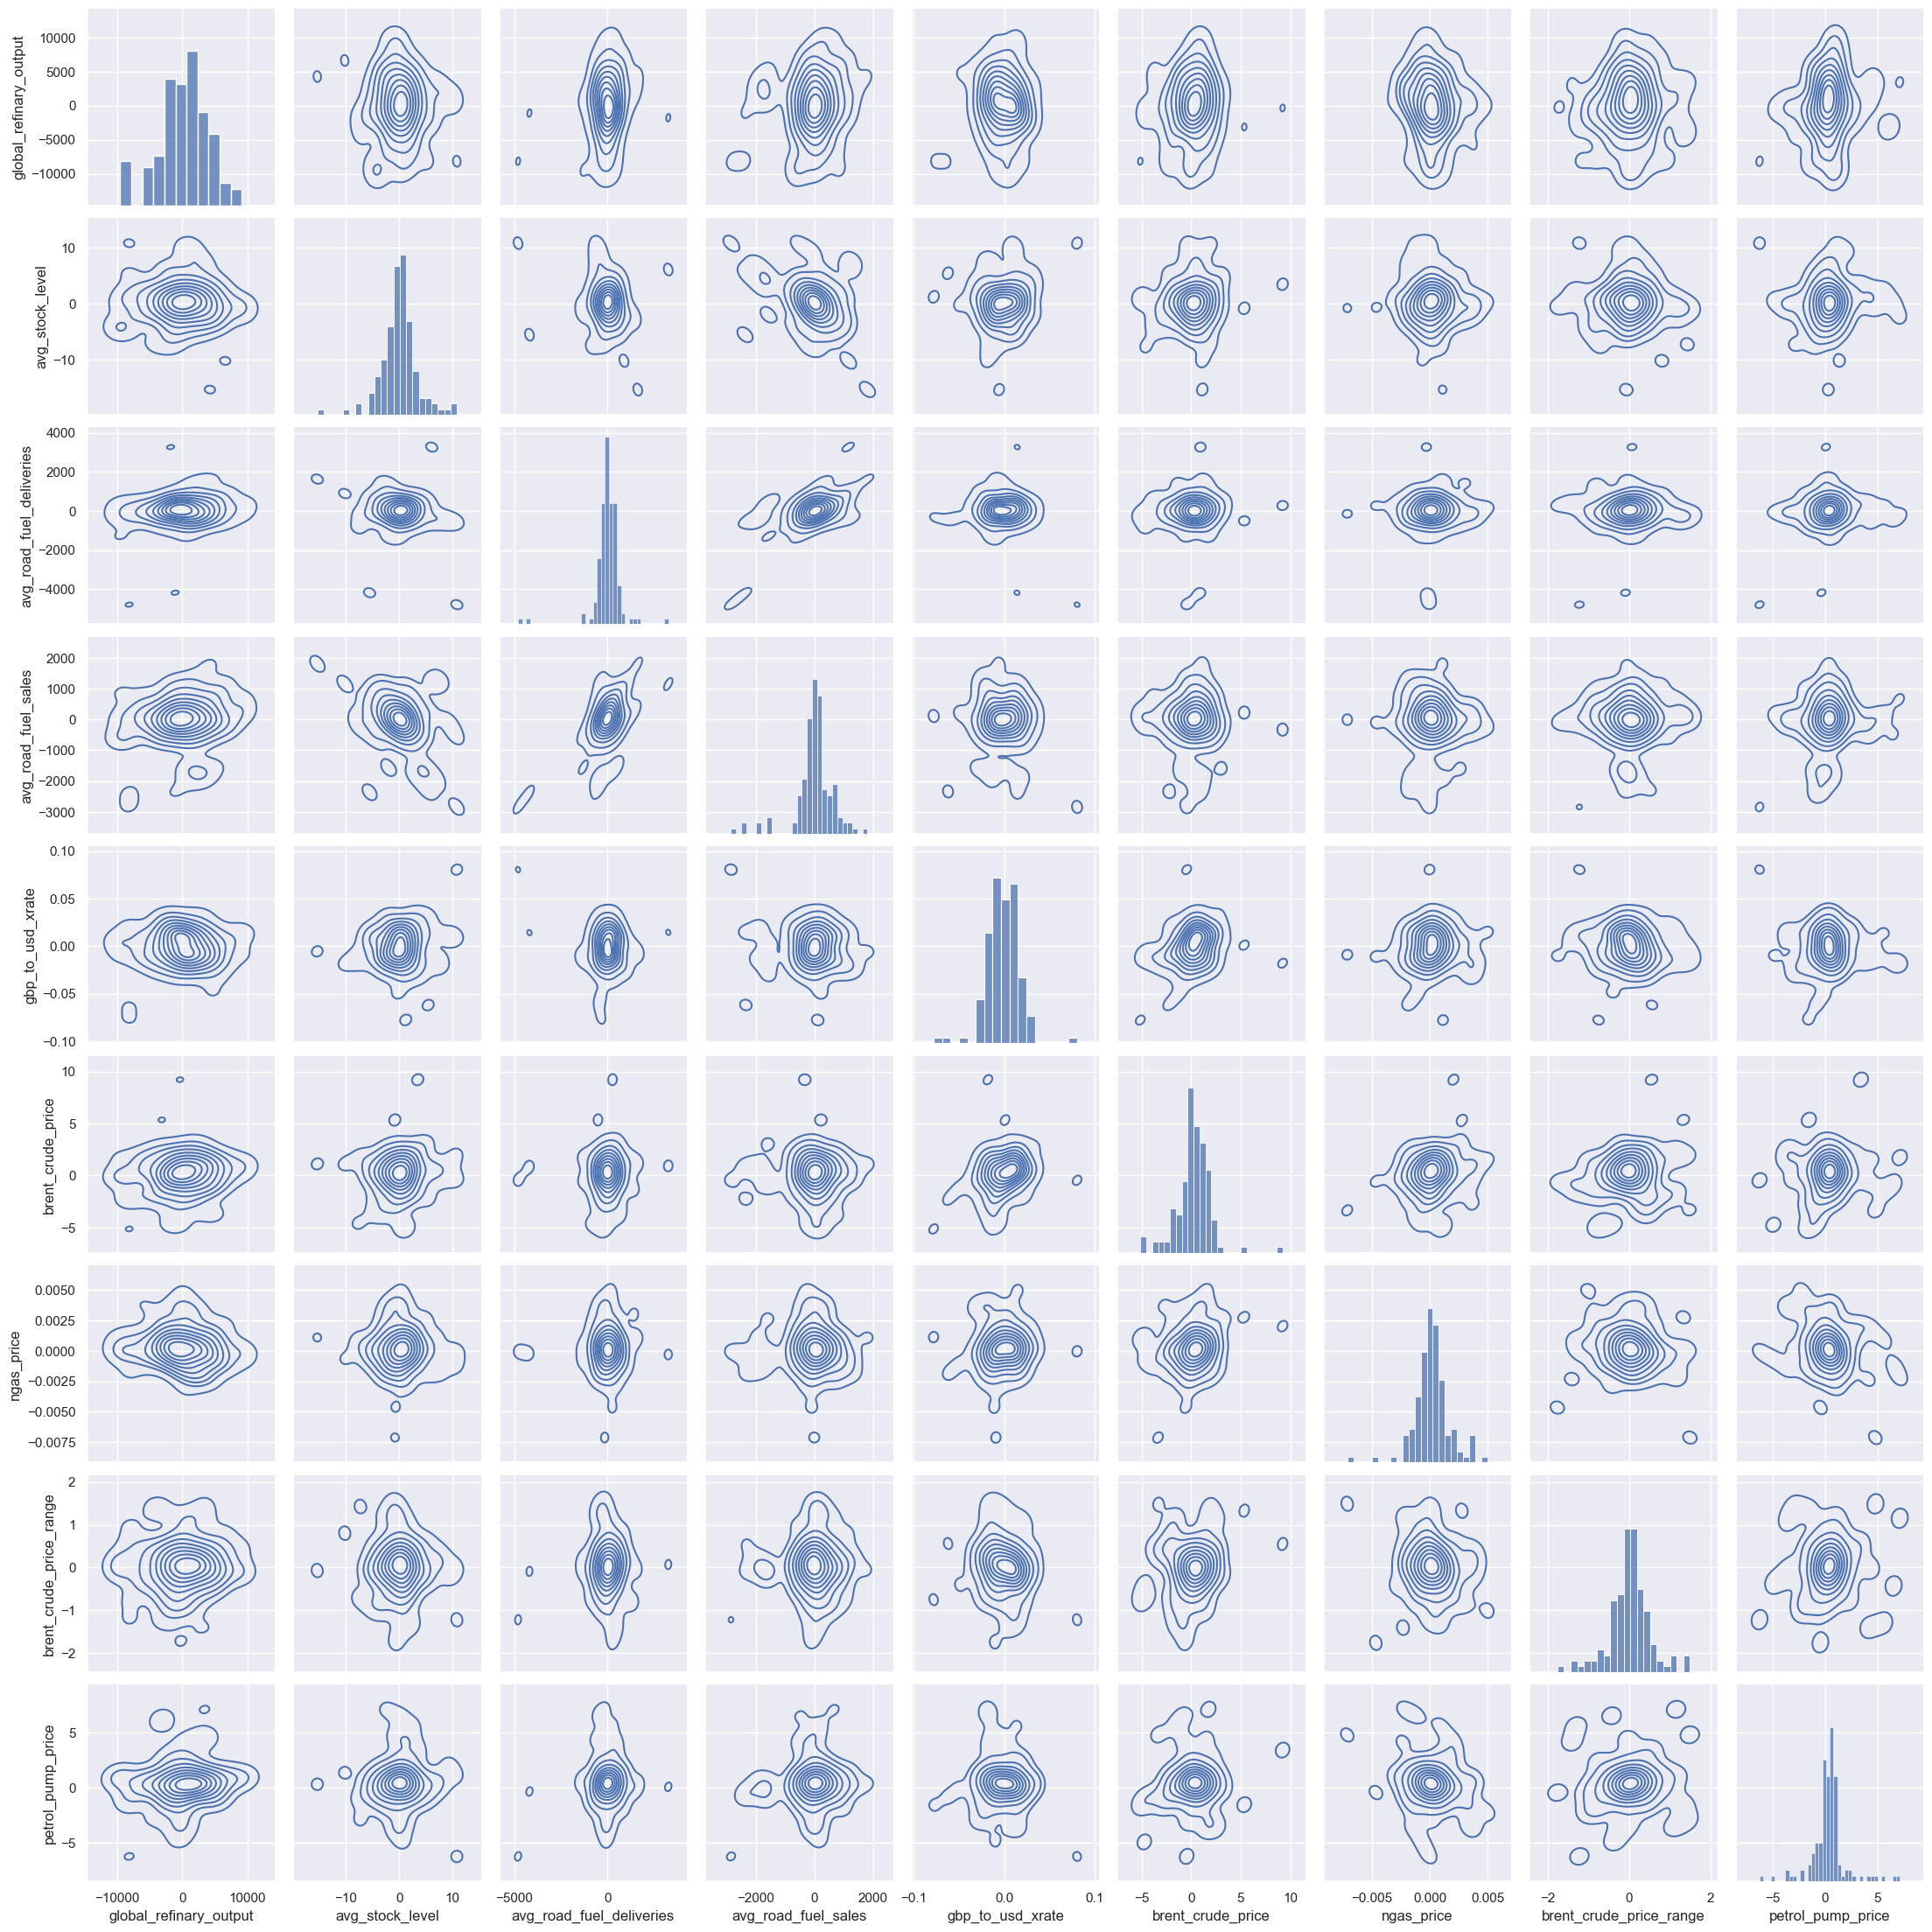

In [13]:
sns.pairplot(
    data=stationary_df,
    vars=features + [target],
    kind='kde',
    diag_kind='hist'
)

Not much in the way of clear correlations, save for between `avg_road_fuel_sales`, `avg_stock_level` and `avg_road_fuel_deliveries`.  These make sense: lots of deliveries are made when stock levels are low, which is correlated to high levels of sales. 

There is possibly a weak, positive relationship between the `gbp_to_usd_xrate` and `brent_crude_price`.  It's hard to see any other firm relationships above.  We'll need to draw upon some slightly more sophisticated statistics to detect (potentially) causal information between our different time series.

The following code calculates _Spearman's Rho_ - a non-parametric measure of correlation between time series.  We check each feature at a lag of up to 10 for its correlation with the target (`petrol_pump_price`).  Only correlations with a test statistic in the 5% critical region are reported.

In [14]:
def lagged_corr(features, max_lag=10, p_crit=0.05):
    
    def check_lag(result, f, l):
        rho = np.round(result.correlation, 2)
        p = np.round(result.pvalue, 2)
        if p <= p_crit:
            yield {'var': f, 'lag': l, 'rho': rho}
    
    for f in features:
        result = spearmanr(stationary_df[target], stationary_df[f])
        yield from check_lag(result, f, 0)
        
        for l in range(1, max_lag+1):
            result = spearmanr(stationary_df[target][l:], stationary_df[f][:-l])
            yield from check_lag(result, f, l)
                
pd.DataFrame(list(lagged_corr(features))).sort_values('rho')

var  lag   rho
3   global_refinary_output    7 -0.26
4   global_refinary_output    8 -0.24
5   global_refinary_output    9 -0.19
13       brent_crude_price    8  0.17
0   global_refinary_output    1  0.19
14              ngas_price    7  0.20
6        brent_crude_price    1  0.22
12       brent_crude_price    7  0.22
2   global_refinary_output    3  0.23
1   global_refinary_output    2  0.24
11       brent_crude_price    6  0.29
9        brent_crude_price    4  0.31
7        brent_crude_price    2  0.32
10       brent_crude_price    5  0.34
8        brent_crude_price    3  0.37

So we have some modest correlations here, but only for the `global_refinary_output`, `brent_crude_price` and `ngas_price` series.  This suggests a Vector Auto-regression model may work well for us.  There may be correlations between the non-target time series too.  We'll explore that possibility further down in the notebook.

# Cross-Validation

We're going to compare several methods for forecasting the `petrol_pump_price`.  In general, our strategy will be:

1. Split the data into several cross-validation folds, each fold containing `forecast_period` steps in the test set.
2. Train each potential parameter set of the model against each fold in the CV dataset and record it's performance on the evaluation set for each fold.
3. Find the parameter set which minimises the MAE across all the validation sets.
4. Using this parameter set, re-fit the model on each fold and plot the forecasts vs actuals.
5. At the end of the notebook, report the MAE and $R^2$ values for each method.

We'll use the same CV-folds for each experiment.

In [15]:
kfolds = list(TimeSeriesSplit(n_splits=5, test_size=FORECAST_PERIOD).split(stationary_df))

# Naive Forecasting

Although we have some evidence that a VAR model is going to work well, it's always important to have a few "baseline" models to compare it against.  The first baseline model should simply be "predict yesterday".  Hopefully it doesn't end up being the best forecaster, else I'm out of a job.

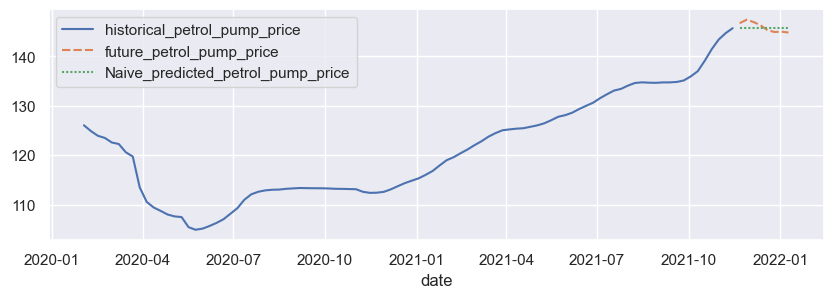

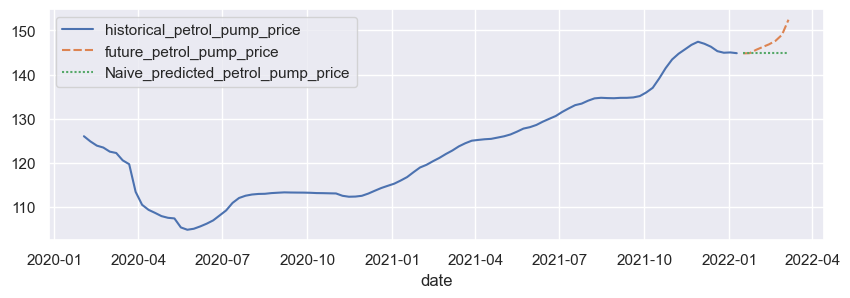

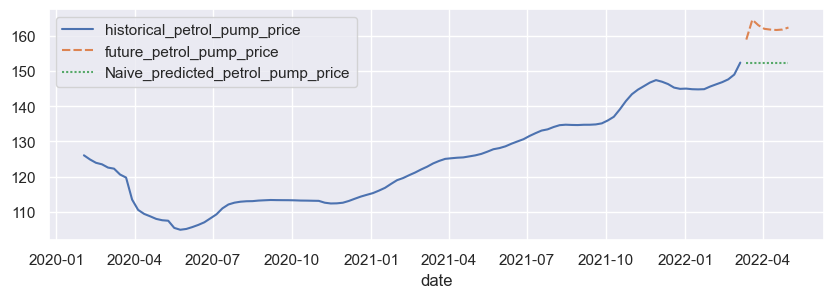

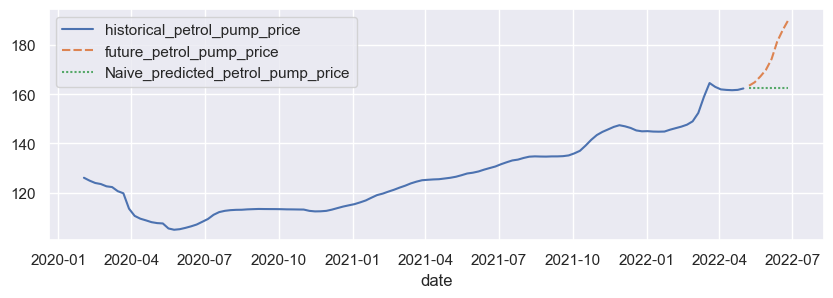

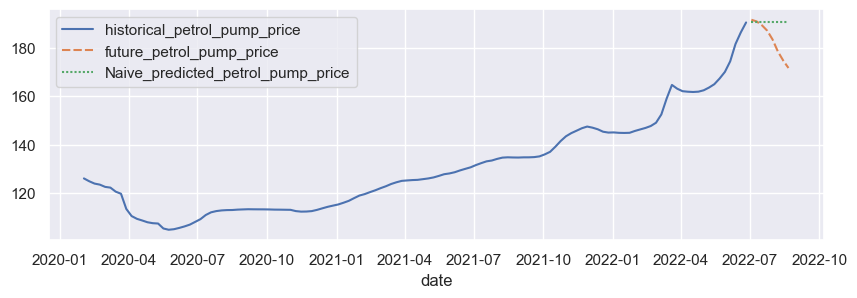

In [16]:
sns.set(rc={'figure.figsize':(10,3)})

y_test_history = y_pred_history = np.array([], dtype=float)

for train_idx, test_idx in kfolds:

    # The "state" is simply the value of the target series on the last timestep of the training period.
    x_state = df[target].iloc[train_idx.max()]
    
    lbl_train = df[date].iloc[train_idx]
    lbl_test = df[date].iloc[test_idx]    
    y_train = df[target].iloc[train_idx]
    y_test = df[target].iloc[test_idx]

    y_pred = [x_state] * FORECAST_PERIOD
    
    y_test_history = np.append(y_test_history, y_test)
    y_pred_history = np.append(y_pred_history, y_pred)    

    plot_df = pd.concat([
        pd.DataFrame({date: lbl_train, f'historical_{target}': y_train}),
        pd.DataFrame({date: lbl_test, f'future_{target}': y_test}),
        pd.DataFrame({date: lbl_test, f'Naive_predicted_{target}': y_pred})
    ]).set_index(date)

    sns.lineplot(plot_df)
    plt.show()

In [17]:
NAIVE_MAE = metrics.mean_absolute_error(y_test_history, y_pred_history)
NAIVE_R2 = metrics.r2_score(y_test_history, y_pred_history)
print(f"MAE = {np.round(NAIVE_MAE, 2)}\tR^2 = {np.round(NAIVE_R2, 2)}")

MAE = 6.54	R^2 = 0.64


# Simple Exponential Smoothing

Although a univariate method, the Holt-Winters method for exponential smoothing can often give excellent results and should always be included as a baseline model.  Here it has been applied without a seasonality component.  As it is fast to fit we can search a large parameter grid for the optimal values.

In [18]:
param_grid = {
    'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90, .99], 
    'smoothing_trend':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90, .99],
    'damping_trend': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
    'damped_trend' : [True, False]
}

hw_param_grid = list(ParameterGrid(param_grid))

hw_results_df = pd.DataFrame(
    columns=['smoothing_level','smoothing_trend', 'damping_trend','damped_trend','MAE', 'R2']
)

for params in tqdm(hw_param_grid):   
    
    y_test_history = y_pred_history = np.array([], dtype=float)
    
    for train_idx, test_idx in kfolds:
        
        lbl_train = df[date].iloc[train_idx]
        lbl_test = df[date].iloc[test_idx]
        y_train = df[target].iloc[train_idx]
        y_test = df[target].iloc[test_idx]
        
        hw_smoother = ExponentialSmoothing(
            endog=y_train, 
            trend='additive', 
            seasonal=None,
            use_boxcox=False,        
            damped_trend=params.get('damped_trend'),
            missing='drop'
        )

        hw_fit = hw_smoother.fit(
            smoothing_level=params.get('smoothing_level'), 
            smoothing_trend=params.get('smoothing_trend'), 
            damping_trend=params.get('damping_trend'),
            smoothing_seasonal=None,
            optimized=False
        )

        y_pred = hw_fit.forecast(FORECAST_PERIOD)        
        y_test_history = np.append(y_test_history, y_test)
        y_pred_history = np.append(y_pred_history, y_pred)

    MAE = metrics.mean_absolute_error(y_test_history, y_pred_history)
    R2 = metrics.r2_score(y_test_history, y_pred_history)
    
    row_df = pd.DataFrame([{
        **params,
        'MAE':MAE,
        'R2': R2,
        'params': params
    }])

    hw_results_df = pd.concat([hw_results_df, row_df], ignore_index=True)
    
hw_params = (
    hw_results_df
    .sort_values(by=['MAE', 'R2'], ascending=[True, False])
    .params
    .iloc[0]
)

(
    hw_results_df
    .sort_values(['MAE', 'R2'], ascending=[True, False])
    .drop('params', axis='columns')
    .head(1)
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:38<00:00, 47.34it/s]


smoothing_level  smoothing_trend  damping_trend damped_trend       MAE  \
299             0.99             0.99            0.3         True  6.490849   

          R2  
299  0.63859

Now we fit using the best parameter values and plot the forecasts.

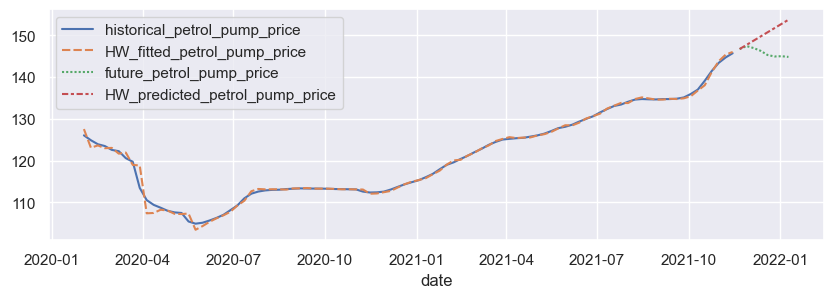

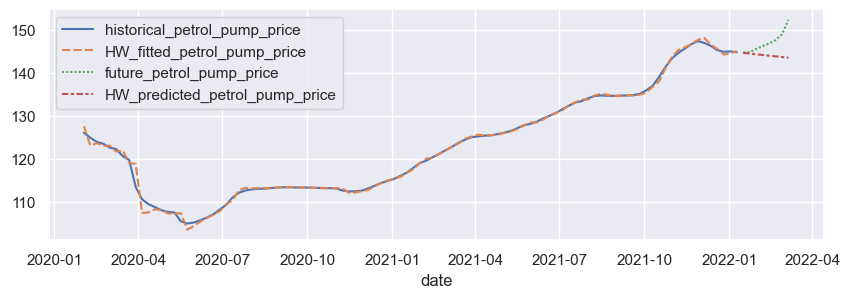

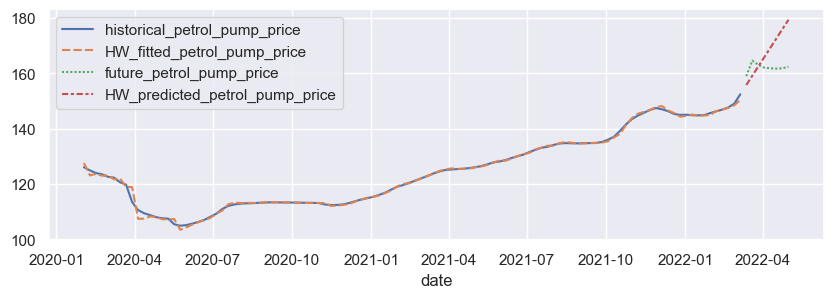

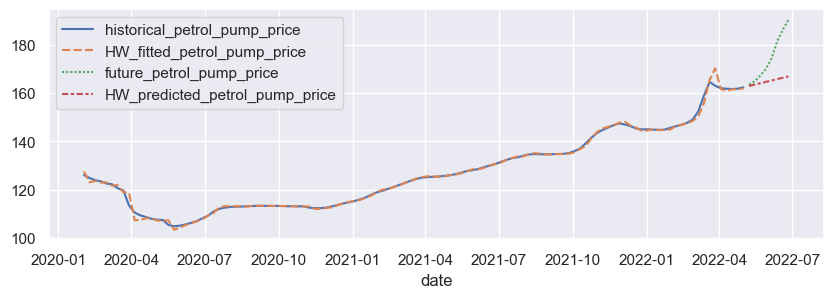

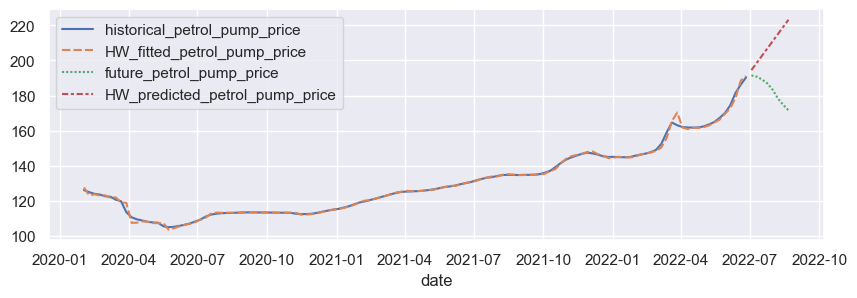

In [19]:
sns.set(rc={'figure.figsize':(10,3)})

for train_idx, test_idx in kfolds:

    lbl_train = df[date].iloc[train_idx]
    lbl_test = df[date].iloc[test_idx]
    y_train = df[target].iloc[train_idx]
    y_test = df[target].iloc[test_idx]

    hw_smoother = ExponentialSmoothing(
        endog=y_train,
        trend='additive',
        seasonal=None,
        use_boxcox=False,
        missing='drop',
        damped_trend=params.get('damped_trend')
    )

    hw_fit = hw_smoother.fit(
        smoothing_level=hw_params.get('smoothing_level'), 
        smoothing_trend=hw_params.get('smoothing_trend'), 
        damping_trend=hw_params.get('damping_trend'),
        smoothing_seasonal=None,
        optimized=False    
    )

    y_pred = hw_fit.forecast(FORECAST_PERIOD)

    plot_df = pd.concat([
        pd.DataFrame({date: lbl_train, f'historical_{target}': y_train}),
        pd.DataFrame({date: lbl_train, f'HW_fitted_{target}': hw_fit.fittedvalues}),
        pd.DataFrame({date: lbl_test, f'future_{target}': y_test}),
        pd.DataFrame({date: lbl_test, f'HW_predicted_{target}': y_pred})
    ]).set_index(date)

    sns.lineplot(plot_df)
    plt.show()

# Prophet

Facebook's Prophet model has become one of the "go to" forecasting models for data scientists.  Again, it's a univariate method (although static covariates are supported) it can often do a good job of responding appropriately to a changing trend.  The seasonality detection module (which works by taking Fourier components) works quite nicely too.

I always prefer to specify the changepoints by hand rather than scatter them uniformly throughout the series.  Below we create changepoints for significant events during the observation period which appear to correlate to changes in the trend.

We disable yearly seasonality in the model below.  (The data is at weekly level so we ignore daily & weekly too.)  Monthly seasonality (every 4 periods) is included.

In [20]:
prophet_df = pd.DataFrame({'ds': df[date], 'y': df[target]})
prophet_train_df = prophet_df[0:-FORECAST_PERIOD]
prophet_val_df = prophet_df[-FORECAST_PERIOD:]

In [21]:
changepoints=[
    '2020-03-16',    # The start of the first of the UK's Coronavirus "lockdowns"
    '2020-06-01',    # Phased lifting of UK lockdown restrictions
    '2020-11-05',    # Re-introduction of UK lockdown restrictions
    '2021-10-01',    # More lockdown restrictions lifted around now.
    '2021-11-27',    # The final lifting of the UK's Coronavirus travel restrictions
    '2022-02-22',    # Commencement of the Russian invasion of the Ukraine
    '2022-03-14',    # UK presents credible plan for phasing out Russian oil & gas
    '2022-05-05',    # Announcements by European Commission to embargo Russian gas & oil
]   

In [63]:
prophet_param_grid = {
    'seasonality_mode': ['multiplicative', 'additive'], 
    'changepoint_prior_scale': [0.4, 0.6, 0.8, 1.],
    'monthly_seasonality_fourier_order': [1, 2, 3],
    'monthly_seasonality_prior_scale': [0.2, 0.4, 0.6]
}

prophet_param_grid = list(ParameterGrid(prophet_param_grid))

prophet_results_df = pd.DataFrame(
    columns=['seasonality_mode', 'changepoint_prior_scale','monthly_seasonality_fourier_order',
             'monthly_seasonality_prior_scale', 'MAE', 'R2']
)

for params in tqdm(prophet_param_grid):
    
    y_test_history = y_pred_history = np.array([], dtype=float)
    
    for train_idx, test_idx in kfolds:
        
        lbl_train = df[date].iloc[train_idx]
        lbl_test = df[date].iloc[test_idx]
        y_train = df[target].iloc[train_idx]
        y_test = df[target].iloc[test_idx]
        
        training_changepoints = [c for c in changepoints if pd.to_datetime(c) <= lbl_train.max()]
        
        prophet_model = Prophet(
            changepoints=training_changepoints,
            seasonality_mode=params.get('seasonality_mode'),
            changepoint_prior_scale=params.get('changepoint_prior_scale'),
            daily_seasonality=False,            
            weekly_seasonality=False,
            yearly_seasonality=False,
            # allow changes to the trend near the end of the series
            changepoint_range=0.9
        )        
        
        prophet_model.add_seasonality(
            name='monthly', 
            period=4, 
            fourier_order=params.get('monthly_seasonality_fourier_order'), 
            prior_scale=params.get('monthly_seasonality_prior_scale')
        )
        
        prophet_train_df = pd.DataFrame({'ds': lbl_train, 'y': y_train})
        prophet_model.fit(prophet_train_df)
        prophet_future_df = prophet_model.make_future_dataframe(periods=FORECAST_PERIOD)
        prophet_fcst_df = prophet_model.predict(prophet_future_df)
        y_pred = prophet_fcst_df[-FORECAST_PERIOD:].yhat.values

        y_test_history = np.append(y_test_history, y_test)
        y_pred_history = np.append(y_pred_history, y_pred)

    MAE = metrics.mean_absolute_error(y_test_history, y_pred_history)
    R2 = metrics.r2_score(y_test_history, y_pred_history)
    
    row_df = pd.DataFrame([{
        **params,
        'MAE':MAE,
        'R2': R2,
        'params': params
    }])

    prophet_results_df = pd.concat([prophet_results_df, row_df], ignore_index=True)
    
prophet_params = prophet_results_df.sort_values(by=['MAE', 'R2'], ascending=[True, False]).params.iloc[0]
prophet_results_df.sort_values(['MAE', 'R2'], ascending=[True, False]).drop('params', axis='columns').head(1)  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [06:36<00:00,  5.51s/it]


seasonality_mode  changepoint_prior_scale  \
61         additive                      1.0   

   monthly_seasonality_fourier_order  monthly_seasonality_prior_scale  \
61                                 2                              0.2   

         MAE        R2  
61  6.481937  0.651386

Again, we re-fit using the best parameter values and plot the forecasts.

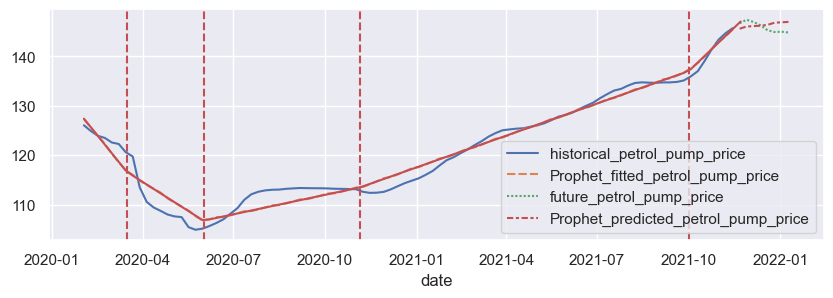

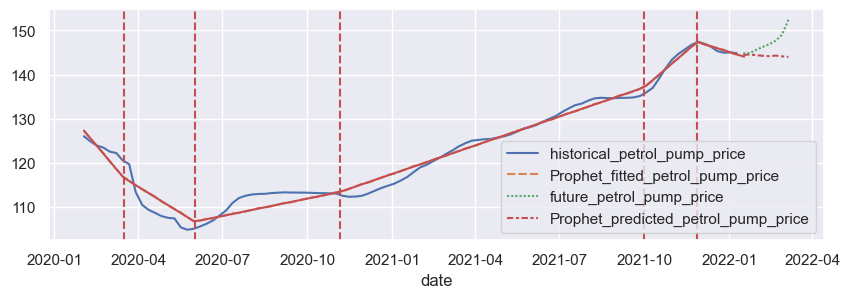

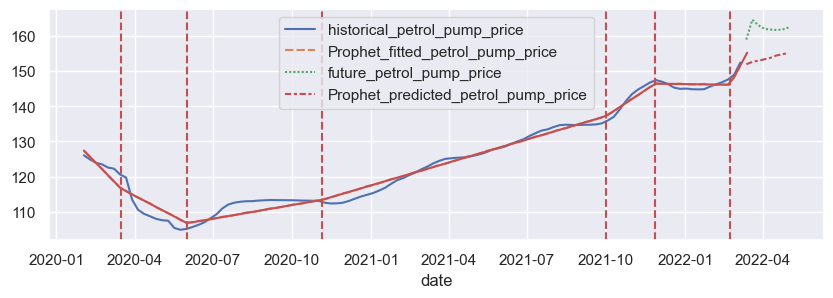

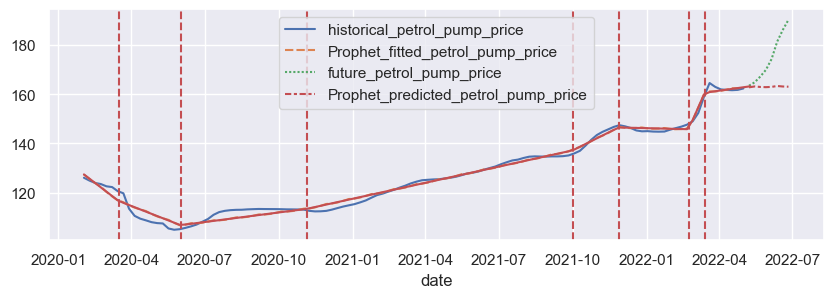

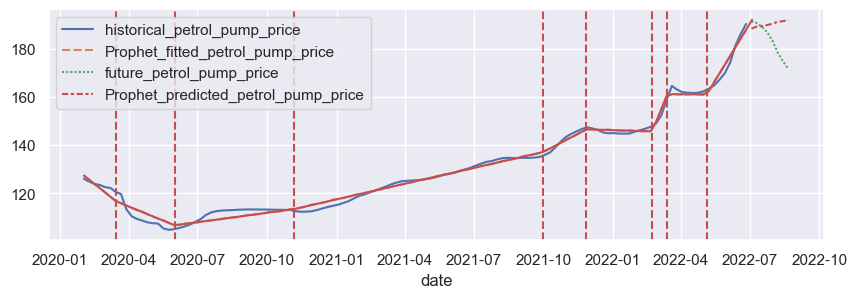

In [64]:
sns.set(rc={'figure.figsize':(10,3)})

for train_idx, test_idx in kfolds:

    lbl_train = df[date].iloc[train_idx]
    lbl_test = df[date].iloc[test_idx]
    y_train = df[target].iloc[train_idx]
    y_test = df[target].iloc[test_idx]

    training_changepoints = [c for c in changepoints if pd.to_datetime(c) <= lbl_train.max()]
    
    prophet_model = Prophet(
        changepoints=training_changepoints,
        seasonality_mode=prophet_params.get('seasonality_mode'),
        changepoint_prior_scale=prophet_params.get('changepoint_prior_scale'),
        daily_seasonality=False,            
        weekly_seasonality=False,
        yearly_seasonality=False,
    )        

    prophet_model.add_seasonality(
        name='monthly', 
        period=4, 
        fourier_order=prophet_params.get('monthly_seasonality_fourier_order'), 
        prior_scale=prophet_params.get('monthly_seasonality_prior_scale')
    )

    prophet_train_df = pd.DataFrame({'ds': lbl_train, 'y': y_train})
    prophet_model.fit(prophet_train_df)
    prophet_future_df = prophet_model.make_future_dataframe(periods=FORECAST_PERIOD)
    prophet_fcst_df = prophet_model.predict(prophet_future_df)
    
    y_pred = prophet_fcst_df[-FORECAST_PERIOD:].yhat.values
    y_fitted = prophet_model.predict().yhat.values

    plot_df = pd.concat([
        pd.DataFrame({date: lbl_train, f'historical_{target}': y_train}),
        pd.DataFrame({date: lbl_train, f'Prophet_fitted_{target}': y_fitted}),
        pd.DataFrame({date: lbl_test, f'future_{target}': y_test}),
        pd.DataFrame({date: lbl_test, f'Prophet_predicted_{target}': y_pred})
    ]).set_index(date)

    sns.lineplot(plot_df)
    
    add_changepoints_to_plot(plt.gca(), prophet_model, prophet_fcst_df)
    
    plt.show()

# Vector Autoregression

The calculations of Spearman's Rho, above, provided some evidence of lagged correlations between the target and some of the other time series.  We can conduct a more sophisticated analysis by testing whether there is evidence for causal, predictive power between _all_ pairs of series.  Granger's Causality Test is one way to do this.  The code below evaluates the test, which tests the null hypothesis that there is no causal relationship between a predictor and a response at a given lag interval.

We conduct Granger's test for each permutation of a pair of series (because we need to test whether A -> B and whether B -> A for each pair) up to a maximum lag which we set somewhat arbitrarily (but with reference to the maximum lag we saw in the previous Spearman's Rho calculations).  For each permutation we then select the lag order with the minimum p value.

The table shows predictors along the top and responses down the side.  Only p values <= 0.05 are shown.

In [24]:
# We set this by checking the maximum lag from the Spearman's Rho calculations done during the initial EDA phase.
max_lags = 9

# Consider only potential causal effects where the p value exceeds this threshold.
p_crit = 0.05

granger_vars = features + [target]

granger_df = pd.DataFrame(
    np.zeros((len(granger_vars), len(granger_vars))), 
    columns=granger_vars, 
    index=granger_vars
)

for c in granger_df.columns:
    for r in granger_df.index:
        test_result = grangercausalitytests(stationary_df[[r, c]], maxlag=max_lags, verbose=False)
        p_values = [test_result[i+1][0]['ssr_chi2test'][1] for i in range(max_lags)]
        min_p_value = np.min(p_values).round(3) if np.min(p_values) <= p_crit else pd.NA
        granger_df.loc[r, c] = min_p_value
        
granger_df.columns = [v + '_PREDICTOR' for v in granger_vars]
granger_df.index = [v + '_RESPONSE' for v in granger_vars]

granger_df

global_refinary_output_PREDICTOR  \
global_refinary_output_RESPONSE                               <NA>   
avg_stock_level_RESPONSE                                       0.0   
avg_road_fuel_deliveries_RESPONSE                            0.004   
avg_road_fuel_sales_RESPONSE                                 0.003   
gbp_to_usd_xrate_RESPONSE                                    0.003   
brent_crude_price_RESPONSE                                   0.003   
ngas_price_RESPONSE                                           <NA>   
brent_crude_price_range_RESPONSE                              <NA>   
petrol_pump_price_RESPONSE                                   0.002   

                                  avg_stock_level_PREDICTOR  \
global_refinary_output_RESPONSE                         0.0   
avg_stock_level_RESPONSE                               <NA>   
avg_road_fuel_deliveries_RESPONSE                       0.0   
avg_road_fuel_sales_RESPONSE                           <NA>   
gbp_to_usd_xrate_RESPONSE                              <NA>   
brent_crude_price_RESPONSE                            0.043   
ngas_price_RESPONSE                                    0.01   
brent_crude_price_range_RESPONSE                       <NA>   
petrol_pump_price_RESPONSE                             <NA>   

                                  avg_road_fuel_deliveries_PREDICTOR  \
global_refinary_output_RESPONSE                                  0.0   
avg_stock_level_RESPONSE                                       0.009   
avg_road_fuel_deliveries_RESPONSE                               <NA>   
avg_road_fuel_sales_RESPONSE                                    <NA>   
gbp_to_usd_xrate_RESPONSE                                       <NA>   
brent_crude_price_RESPONSE                                      <NA>   
ngas_price_RESPONSE                                            0.023   
brent_crude_price_range_RESPONSE                                <NA>   
petrol_pump_price_RESPONSE                                      <NA>   

                                  avg_road_fuel_sales_PREDICTOR  \
global_refinary_output_RESPONSE                           0.004   
avg_stock_level_RESPONSE                                  0.022   
avg_road_fuel_deliveries_RESPONSE                           0.0   
avg_road_fuel_sales_RESPONSE                               <NA>   
gbp_to_usd_xrate_RESPONSE                                  0.02   
brent_crude_price_RESPONSE                                 <NA>   
ngas_price_RESPONSE                                       0.002   
brent_crude_price_range_RESPONSE                           <NA>   
petrol_pump_price_RESPONSE                                 <NA>   

                                  gbp_to_usd_xrate_PREDICTOR  \
global_refinary_output_RESPONSE                         <NA>   
avg_stock_level_RESPONSE                               0.008   
avg_road_fuel_deliveries_RESPONSE                      0.003   
avg_road_fuel_sales_RESPONSE                             0.0   
gbp_to_usd_xrate_RESPONSE                               <NA>   
brent_crude_price_RESPONSE                              <NA>   
ngas_price_RESPONSE                                     <NA>   
brent_crude_price_range_RESPONSE                       0.035   
petrol_pump_price_RESPONSE                              <NA>   

                                  brent_crude_price_PREDICTOR  \
global_refinary_output_RESPONSE                          <NA>   
avg_stock_level_RESPONSE                                 <NA>   
avg_road_fuel_deliveries_RESPONSE                       0.016   
avg_road_fuel_sales_RESPONSE                            0.002   
gbp_to_usd_xrate_RESPONSE                                <NA>   
brent_crude_price_RESPONSE                               <NA>   
ngas_price_RESPONSE                                     0.016   
brent_crude_price_range_RESPONSE                        0.004   
petrol_pump_price_RESPONSE                                0.0   

                  

Now we're getting somewhere.  There are plenty of potentially causal relationships between the series.  Some look clearly spurious (does `avg_road_fuel_deliveries` really have an effect on `ngas_price`?).  Several of these putative causal relationships will be false positives caused by the large number of Chi-Squared tests (for $N$ variables and $L$ lags we will conduct $L\left(N^2-N\right)$ tests).  If we wanted to make inferences or report on these relationships we should scale the critical p-value according to Bonferroni correction, but for now we'll skip this step and just take comfort that there are highly likely to be lagged correlations that a VAR model can exploit.

The function below take a subset of the tests and shows the most informative lag between a series and the target variable.  Note that it correlates well with the Spearman's Rho calculations above.

In [25]:
def check_causality(df, feature, target, max_lags, p_crit):
    
    results = grangercausalitytests(
        df[[target, feature]], 
        maxlag=max_lags, 
        verbose=False
    )
    p_values = [results[lag][0]['ssr_chi2test'][1] for lag in range(1, max_lags+1)]
    
    min_idx = np.argmin(p_values)
    
    if p_values[min_idx] <= p_crit:
        return {'feature': feature, 'lag': min_idx + 1, 'p_value': p_values[min_idx]}
    else:
        return {'feature': feature, 'lag': pd.NA, 'p_value': pd.NA}

    
pd.DataFrame([check_causality(stationary_df, f, target, max_lags, p_crit) for f in features]).dropna()

feature lag   p_value
0   global_refinary_output   4  0.001852
5        brent_crude_price   2       0.0
6               ngas_price   8  0.000437
7  brent_crude_price_range   9  0.000655

Now we have a decision to make.  The full VAR model contains the same number of parameters as the number of Granger Causality tests we performed above.  Given that we have only a few years of data it would be easy to specify model with more parameters than datapoints.  To avoid this we'll reduce the number of features we consider to those for which we have good evidence of causal power over the target.

In [26]:
VAR_features = ['global_refinary_output', 'brent_crude_price', 'ngas_price', 'brent_crude_price_range']

_Quick note: if we were working with non-stationary time series then at this point we'd check that they co-integrate before proceeding to fit a VAR model.  I'm happy that our time series are stationary enough (notwithstanding some minor concerns about heteroskedastic variances)._

First we check whether the VAR model can select an appropriate lag order.  Standard practise is to evaluate the lag order which yields the best AIC.

In [27]:
var_model = VAR(stationary_df[VAR_features + [target]])
var_model.select_order(maxlags=20).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

Note that the AIC decreases with each additional lag, suggesting overfitting.  So we'll have to test the most appropriate lag order via cross-validation.

In [28]:
var_param_grid = {
    'maxlags': list(range(1, 20)), 
}

var_param_grid = list(ParameterGrid(var_param_grid))

var_results_df = pd.DataFrame(columns=['maxlags', 'MAE', 'R2'])

for params in tqdm(var_param_grid):
    
    y_test_history = y_pred_history = np.array([], dtype=float)
    
    for train_idx, test_idx in kfolds:
        
        lbl_train = stationary_df[date].iloc[train_idx]
        lbl_test = stationary_df[date].iloc[test_idx]
        X_train = stationary_df[VAR_features + [target]].iloc[train_idx]
        y_train = df[target].iloc[train_idx]
        y_test = df[target].iloc[test_idx]
        x_state = df[target].iloc[np.max(train_idx)]    
        
        var_model = VAR(X_train.to_numpy())
        
        maxlags = params.get('maxlags')

        # Using OLS (the default, actually) means we don't need to standardise our variables first.
        var_model_fit = var_model.fit(maxlags=maxlags, method='ols')

        forecast = var_model_fit.forecast(y=X_train.to_numpy()[-maxlags:], steps=FORECAST_PERIOD)
        forecast_df = pd.DataFrame(forecast, index=lbl_test, columns= [VAR_features + [target]])

        y_pred = forecast_df[target].values.ravel()
        
        # Undo the stationarity transformation
        y_pred = x_state + y_pred.cumsum()        

        y_test_history = np.append(y_test_history, y_test)
        y_pred_history = np.append(y_pred_history, y_pred)

    MAE = metrics.mean_absolute_error(y_test_history, y_pred_history)
    R2 = metrics.r2_score(y_test_history, y_pred_history)
    
    row_df = pd.DataFrame([{
        **params,
        'MAE':MAE,
        'R2': R2,
        'params': params
    }])

    var_results_df = pd.concat([var_results_df, row_df], ignore_index=True)
    
var_params = var_results_df.sort_values(by=['MAE', 'R2'], ascending=[True, False]).params.iloc[0]
var_results_df.sort_values(['MAE', 'R2'], ascending=[True, False]).drop('params', axis='columns').head(1)  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 42.86it/s]


maxlags     MAE        R2
7       8  3.3657  0.885177

So the most suitable lag order, according to cross-validation, is 8.

In [29]:
var_lag_order = var_params.get('maxlags')
var_model_fit = var_model.fit(var_lag_order)

In [30]:
# var_model_fit.summary()

In [31]:
# Check the values of the Durbin-Watson residuals.  They should be close to 2 if we have extracted all of the information from the time series.
out = durbin_watson(var_model_fit.resid)

for col, val in zip(VAR_features + [target], out):
    print(col, ':', round(val, 2))

global_refinary_output : 1.83
brent_crude_price : 1.91
ngas_price : 2.03
brent_crude_price_range : 1.77
petrol_pump_price : 1.71


Not too bad.  We could possibly improve the fits a bit with some more care & attention.

We'll plot the forecasts over the CV folds below.

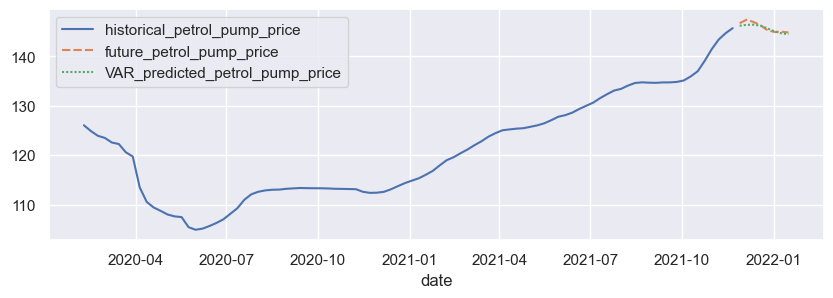

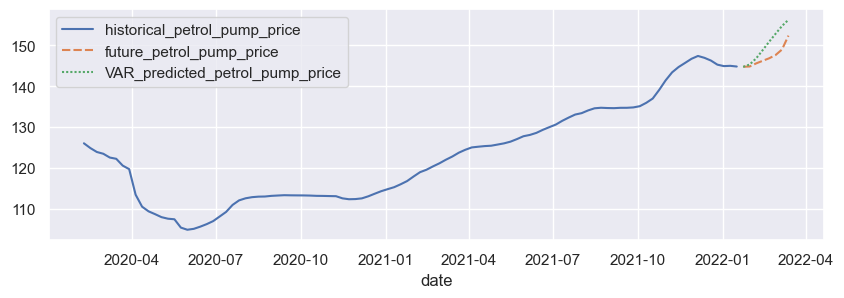

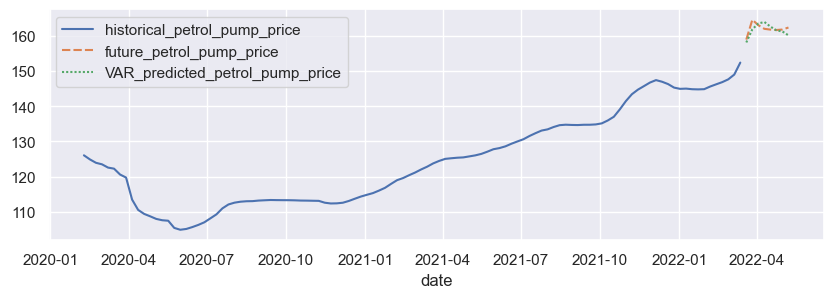

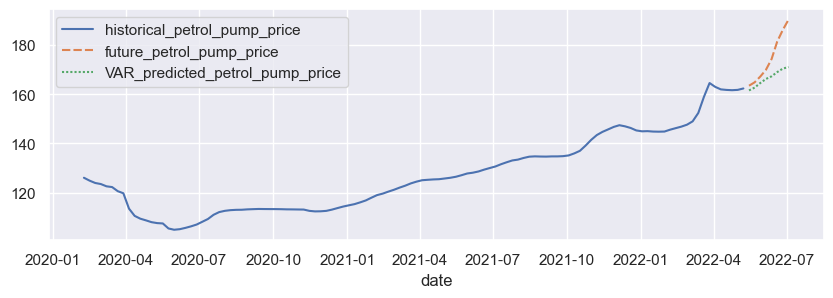

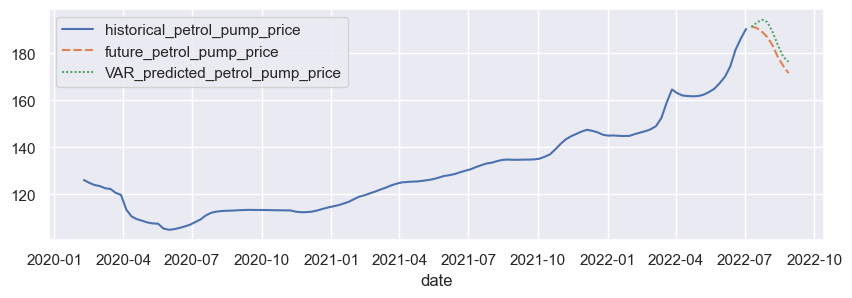

In [65]:
sns.set(rc={'figure.figsize':(10,3)})

y_test_history = y_pred_history = np.array([], dtype=float)
   
for train_idx, test_idx in kfolds:
    
    lbl_train = stationary_df[date].iloc[train_idx]
    lbl_test = stationary_df[date].iloc[test_idx]
    X_train = stationary_df[VAR_features + [target]].iloc[train_idx]
    y_train = df[target].iloc[train_idx]
    y_test = df[target].iloc[test_idx]
    x_state = df[target].iloc[np.max(train_idx)]    

    var_model = VAR(X_train.to_numpy())
    
    # Using OLS (the default, actually) means we don't need to standardise our variables first.
    var_model_fit = var_model.fit(var_lag_order, method='ols')
    
    forecast = var_model_fit.forecast(y=X_train.to_numpy()[-var_lag_order:], steps=FORECAST_PERIOD)
    forecast_df = pd.DataFrame(forecast, index=lbl_test, columns= [VAR_features + [target]])
    
    y_pred = forecast_df[target].values.ravel()
    
    # Undo the stationarity transformation
    y_pred = x_state + y_pred.cumsum()
    
    y_test_history = np.append(y_test_history, y_test)
    y_pred_history = np.append(y_pred_history, y_pred)
    
    plot_df = pd.concat([
        pd.DataFrame({date: lbl_train, f'historical_{target}': y_train}),
        pd.DataFrame({date: lbl_test, f'future_{target}': y_test}),
        pd.DataFrame({date: lbl_test, f'VAR_predicted_{target}': y_pred})
    ]).set_index(date)
    
    sns.lineplot(plot_df)
    plt.show()

In [33]:
VAR_MAE = metrics.mean_absolute_error(y_test_history, y_pred_history)
VAR_R2 = metrics.r2_score(y_test_history, y_pred_history)  
print(f"MAE = {np.round(VAR_MAE, 2)}\tR^2 = {np.round(VAR_R2, 2)}")

MAE = 3.37	R^2 = 0.89


# DeepVAR

In [34]:
# We'll need to use small batch sizes because we don't have that many observations.
# To get stable gradients we'll use a gradient batching schedule that increases over epochs.
batch_size = 4
grad_batch_schedule = {1: 2, 5: 4, 10: 8}

In [35]:
# The maximum encoder length is based on the lag order we identified above.
max_encoder_length = var_lag_order

In the original DeepAR paper from Amazon Research (https://arxiv.org/abs/1704.04110) the authors report standardising the time series during the modelling process.  It's not clear to me whether PyTorch Forecasting does this.  I experimented with and without standardisation and got better results with.  So the following code standardises each series in the stationary data.  We can pass any CV-fold subset of the data into the function.

In [36]:
differenced_series_scaler = StandardScaler()
differenced_series_scaler.fit(stationary_df[VAR_features + [target]])

def scale_stationary_df(df):
    out_df = pd.DataFrame(
        differenced_series_scaler.transform(df[VAR_features + [target]]), 
        columns=differenced_series_scaler.get_feature_names_out()
    )
    out_df[date] = df[date]
    out_df[time_idx] = df[time_idx]
    return out_df

In [37]:
scaled_df = scale_stationary_df(stationary_df)

In [38]:
# Create a label encoder for each series name.  
# Later we can use the inverse transform to find the index of our target series in the output tensor.
series_encoder = NaNLabelEncoder().fit([VAR_features + [target]])

The following code transforms our data into the format expected by Pytorch Forecasting.  It's presented as a function to enable us to apply it across each fold in our CV dataset.

When we're training the model we want to return both a training and validation `TimeSeriesDataSet`.  When we're testing the model we want to return a single `TimeSeriesDataSet` containing all the data in the test set.  We pass a `val_timesteps` value of 0 to the function to achieve this.  A little messy but it saves repeating this code several times.

In [39]:
def deepvar_data_prep(df, forecast_period, val_timesteps):        

    ptf_df = df.melt(
        id_vars=[date, time_idx], 
        value_vars=VAR_features + [target], 
        var_name='series', 
        value_name='value'
    ).sort_values(['series', time_idx])

    cut_off = ptf_df.time_idx.max() - val_timesteps        
    
    training = TimeSeriesDataSet(
        ptf_df[ptf_df.time_idx <= cut_off],
        time_idx=time_idx,
        target='value',
        categorical_encoders={'series': series_encoder},
        group_ids=['series'],
        static_categoricals=['series'],
        time_varying_unknown_reals=['value'],
        max_encoder_length=max_encoder_length,
        max_prediction_length=forecast_period,
    )
    
    if val_timesteps > 0:        
        validation = TimeSeriesDataSet.from_dataset(
            training, ptf_df, min_prediction_idx=cut_off + 1
        )

        return training, validation, cut_off
    
    else:
        return training, None, None

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

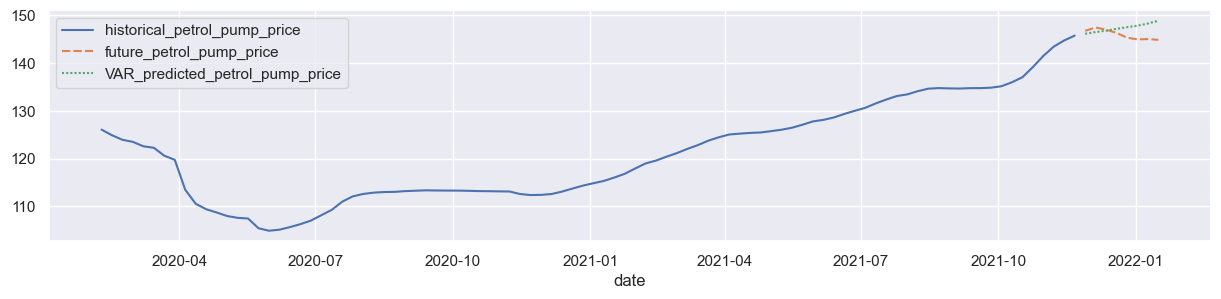

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

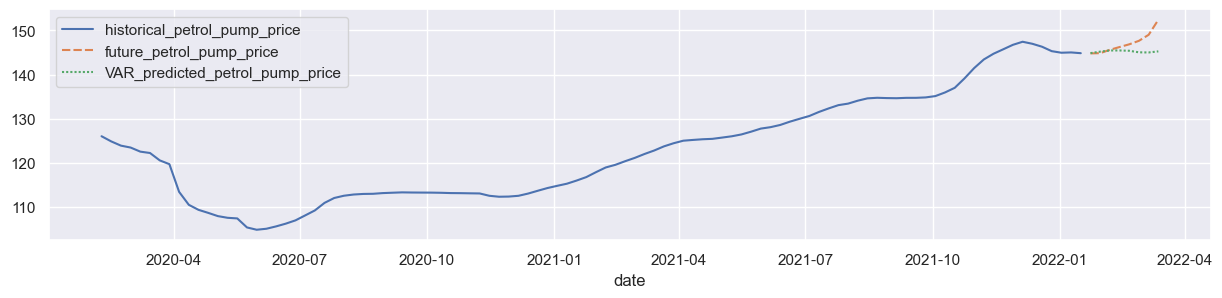

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

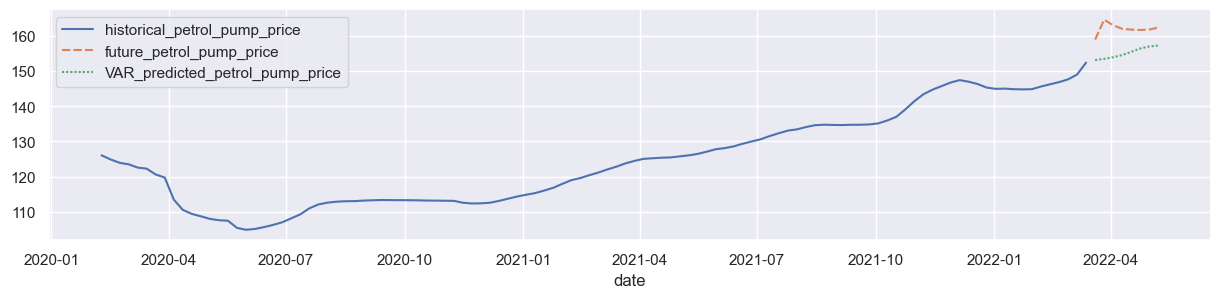

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

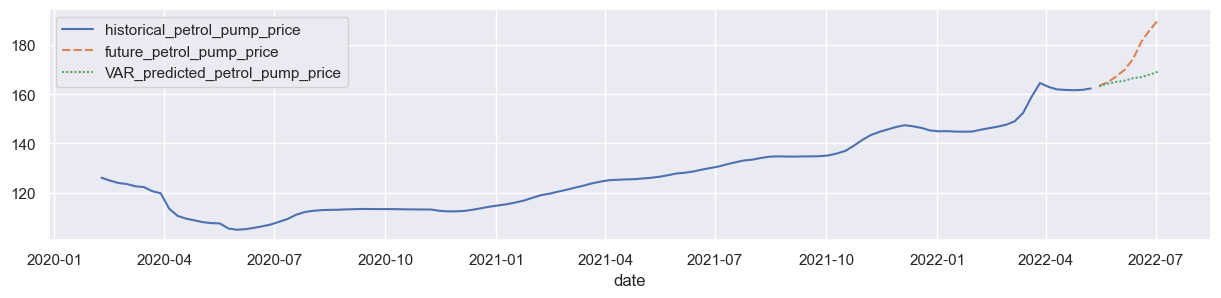

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

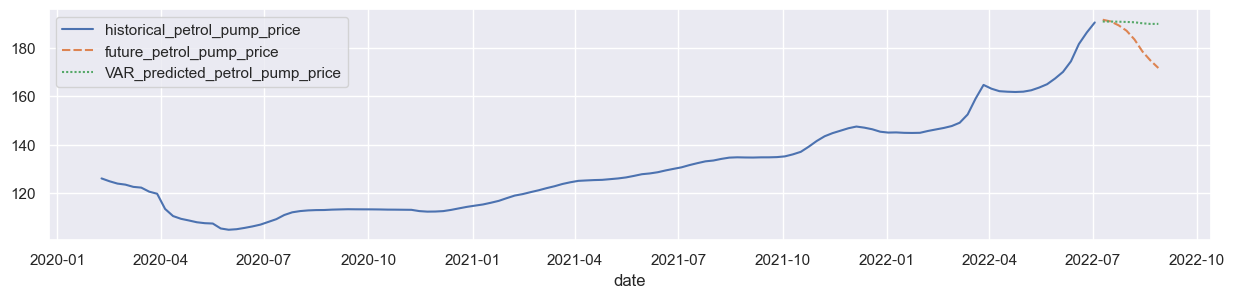

In [56]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=1e-4, 
    patience=10, 
    verbose=False, 
    mode="min"
)

y_test_history = y_pred_history = np.array([], dtype=float)

for train_and_val_idx, test_idx in kfolds:
        
    lbl_val_and_train = scaled_df.iloc[train_and_val_idx][date]
    lbl_test = scaled_df.iloc[test_idx][date]

    X_train, X_val, _ = deepvar_data_prep(
        scaled_df.iloc[train_and_val_idx], FORECAST_PERIOD, FORECAST_PERIOD
    )
    
    # We need to prepend the test time series with enough training timesteps to properly feed the encoder.
    test_idx = np.append(train_and_val_idx[-max_encoder_length:], test_idx)

    X_test, _, _ = deepvar_data_prep(
        scaled_df.iloc[test_idx], FORECAST_PERIOD, 0
    )
    
    y_val_and_train = df.iloc[train_and_val_idx][target].values
    y_test = df.iloc[test_idx][target]
    
    # Used to undo the differencing transformation at prediction-time
    y_state = y_val_and_train[-1]
    
    # Samples from each series need to be synchronised over each batch to enable vector autoregressive properties to be learned.
    train_dataloader = X_train.to_dataloader(
        train=True, batch_size=batch_size, num_workers=12, batch_sampler="synchronized"
    )
    val_dataloader = X_val.to_dataloader(
        train=False, batch_size=batch_size, num_workers=12, batch_sampler="synchronized"
    )
    test_dataloader = X_test.to_dataloader(
        train=False, batch_size=batch_size, num_workers=12, batch_sampler="synchronized"
    )    
    
    deepvar_trainer = pl.Trainer(
        max_epochs=100,
        accelerator='gpu',
        enable_model_summary=False,
        # Clipping is important for LSTMs and other RNNs
        gradient_clip_val=0.1,
        callbacks=[early_stop_callback],
        limit_train_batches=50,
        accumulate_grad_batches=grad_batch_schedule,
        enable_checkpointing=True,
    )

    deepvar_model = DeepAR.from_dataset(
        X_train,
        # I experimented with automatically finding the optimal LR but the suggested rate
        # was worse than just using the default...
        learning_rate=0.001,
        log_interval=10,
        log_val_interval=1,
        hidden_size=30,
        rnn_layers=2,
        # This loss function trains the DeepAR model as a DeepVAR model
        loss=MultivariateNormalDistributionLoss(rank=30),
    )

    deepvar_trainer.fit(
        deepvar_model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    
    # Retrieve the best cached model (lowest validation error).
    deepvar_model = DeepAR.load_from_checkpoint(
        deepvar_trainer.checkpoint_callback.best_model_path
    )    
    
    # Generates an [n_series x forecast_period] tensor
    Y_pred = deepvar_model.predict(test_dataloader)
    
    # Transpose the prediction and invert the standardising transformation
    Y_pred = differenced_series_scaler.inverse_transform(Y_pred.transpose(0,1))
    
    # This is the index of the target series in the prediction tensor
    target_idx = series_encoder.transform([target])[0]
    
    # Select the target series and undo the differencing transformation
    y_pred = y_state + Y_pred[:, target_idx].flatten().cumsum(0)
    
    # Remove the encoder state from y_test
    y_test = y_test[-FORECAST_PERIOD:]
    
    y_test_history = np.append(y_test_history, y_test)
    y_pred_history = np.append(y_pred_history, y_pred)    
       
    plot_df = pd.concat([
        pd.DataFrame({date: lbl_val_and_train, f'historical_{target}': y_val_and_train}),
        pd.DataFrame({date: lbl_test, f'future_{target}': y_test}),
        pd.DataFrame({date: lbl_test, f'VAR_predicted_{target}': y_pred})
    ]).set_index(date)
    
    sns.lineplot(plot_df)
    plt.show()

In [58]:
DEEPVAR_MAE = metrics.mean_absolute_error(y_test_history, y_pred_history)
DEEPVAR_R2 = metrics.r2_score(y_test_history, y_pred_history)
print(f"MAE = {np.round(DEEPVAR_MAE, 2)}\tR^2 = {np.round(DEEPVAR_R2, 2)}")  

MAE = 5.33	R^2 = 0.76


In [ ]:
# Used when training & debugging

# %reload_ext tensorboard
# %tensorboard --logdir=lightning_logs/

# Model Comparison

In [59]:
results_df = pd.DataFrame([
    {
        'MAE': hw_results_df.sort_values(by=['MAE', 'R2']).MAE.iloc[0],
        'R2': hw_results_df.sort_values(by=['MAE', 'R2']).R2.iloc[0]
    },
    {
        'MAE': prophet_results_df.sort_values(by=['MAE', 'R2']).MAE.iloc[0],
        'R2': prophet_results_df.sort_values(by=['MAE', 'R2']).R2.iloc[0]
    },
    {
        'MAE': var_results_df.sort_values(by=['MAE', 'R2']).MAE.iloc[0],
        'R2': var_results_df.sort_values(by=['MAE', 'R2']).R2.iloc[0]
    },    
    {'MAE': DEEPVAR_MAE, 'R2': DEEPVAR_R2},
    {'MAE': NAIVE_MAE, 'R2': NAIVE_R2},
])

results_df.index = ['Holt-Winters', 'Prophet', 'VAR', 'DEEPVAR', 'Naive']

results_df.sort_values(['MAE', 'R2'], ascending=[True, False]).round(2)

MAE    R2
VAR           3.37  0.89
DEEPVAR       5.33  0.76
Holt-Winters  6.49  0.64
Prophet       6.51  0.65
Naive         6.54  0.64

# Conclusions

So the traditional VAR model wins out.  It's fast and flexible.  The downsides are that there is a fair amount of manual analysis required before and after the modelling phase to ensure robust conclusions can be drawn and it's easy to overfit it.  I spent quite a lot of time tuning the DeepVAR model but wasn't able to get better performance out-of-the-box.

If I extend this notebook, it'll be to compare the DeepAR performance with Google's TFT.